## Table of Contents:
1. [Qiskit Components of the Grover Algorythm](#qiskit-components)
2. [4 Qubit Grover Algorithm](#4qubit)
    * [Triple Controlled Z-Gate](#triplez)
    * [Components](#4components)
    * [Double Application of the Oracle and Amplification](#4qubitdouble)
3. [Grover Algorithm for Many-Qubit Systems](#many_qubit)
    * [Many-Qubit controlled Z-Gate](#many_zgate)
    * [Many Qubit Grover Circuit](#many_circuit)
    * [Many Qubit Grover Function](#many_qubit_func)
4. [Number of Oracle and Amplification Apllications and Search Pattern Amplitude](#num_oracle_amp)
    * [Theoretical Predictions of number of necessary Oracles and Amps](#theory_oracles_amps)
5. [Testing Real Devices](#testing)
    * [Theoretical Prediction](#testing_theory)

In [91]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import math
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Qiskit Components of the Grover Algorythm <a class="anchor" id="qiskit-components"></a>

circuit = init + ( oracle + amp ) ** t + meas

#  4 Qubit Grover Algorithm <a class="anchor" id="4qubit"></a>

## Triple Controlled Z-Gate  <a class="anchor" id="triplez"></a>

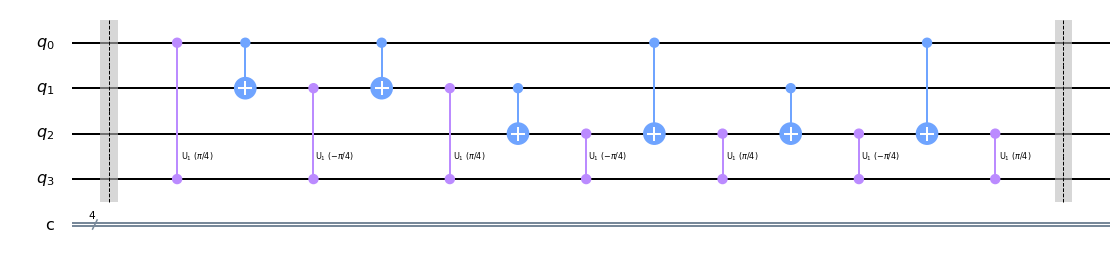

In [92]:
cccz = QuantumCircuit(4, 4)

cccz.barrier()

cccz.cu1(math.pi/4, 0, 3)
cccz.cx(0, 1)
cccz.cu1(-math.pi/4, 1, 3)
cccz.cx(0, 1)
cccz.cu1(math.pi/4, 1, 3)
cccz.cx(1, 2)
cccz.cu1(-math.pi/4, 2, 3)
cccz.cx(0, 2)
cccz.cu1(math.pi/4, 2, 3)
cccz.cx(1, 2)
cccz.cu1(-math.pi/4, 2, 3)
cccz.cx(0, 2)
cccz.cu1(math.pi/4, 2, 3)

cccz.barrier()

cccz.draw()

## Components <a class="anchor" id="4components"></a>

In [6]:
search_pattern = "0011"
circ_length = len(search_pattern) 
qmax = circ_length - 1  

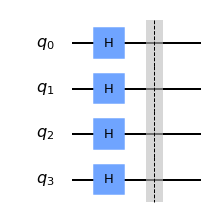

In [7]:
init = QuantumCircuit(circ_length)

for i in range(circ_length):
    init.h(i)
init.barrier()

init.draw()

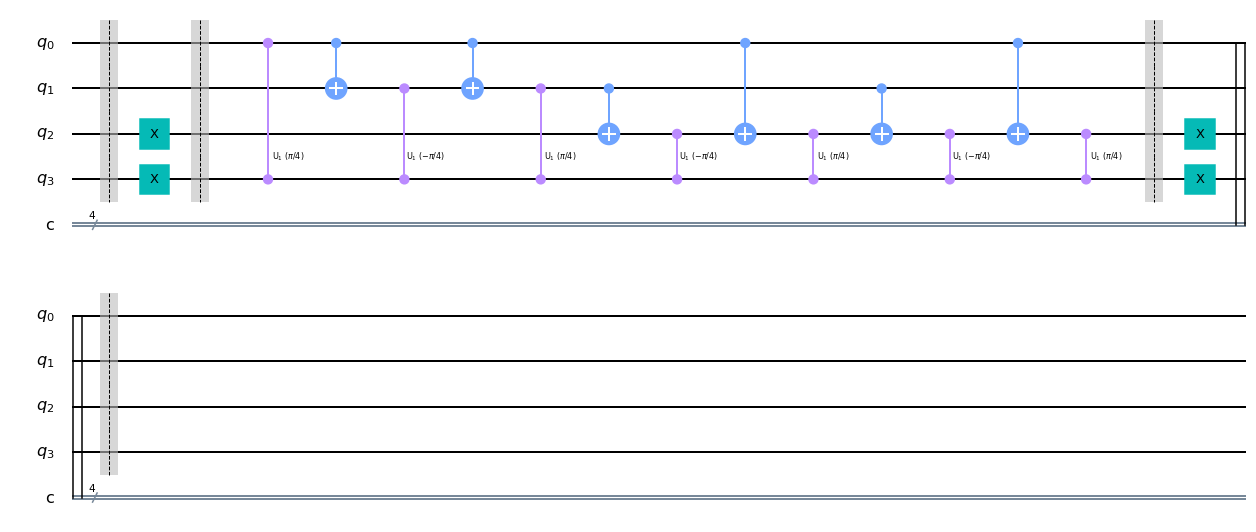

In [8]:
oracle = QuantumCircuit(circ_length)

oracle.barrier()

x_s = -1
for i in search_pattern:
    x_s += 1
    x = int(i)
    if x == 1:
        oracle.x(x_s)
        
oracle_flipped = oracle + cccz

x_s = -1
for i in search_pattern:
    x_s += 1
    x = int(i)
    if x == 1:
        oracle_flipped.x(x_s) 


oracle_flipped.barrier()

oracle_flipped.draw()

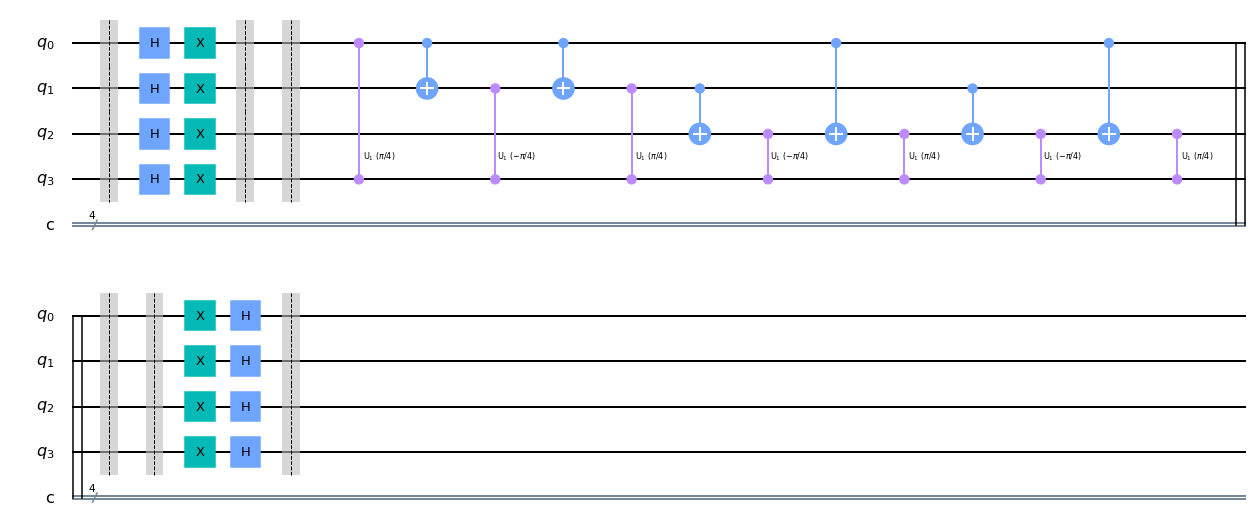

In [9]:
amp = QuantumCircuit(circ_length)

amp.barrier()

for q in range(circ_length):
    amp.h(q)
    amp.x(q)
    
amp.barrier()
    
amp_flipped = amp + cccz

amp_flipped.barrier()

for q in range(circ_length):
    amp_flipped.x(q)
    amp_flipped.h(q)
      
amp_flipped.barrier()

amp_flipped.draw()

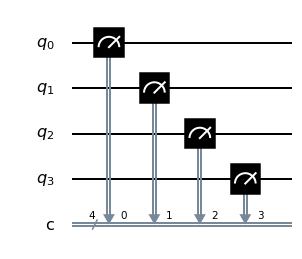

In [10]:
meas = QuantumCircuit(circ_length,circ_length)

meas.measure(range(circ_length),range(circ_length))

meas.draw()

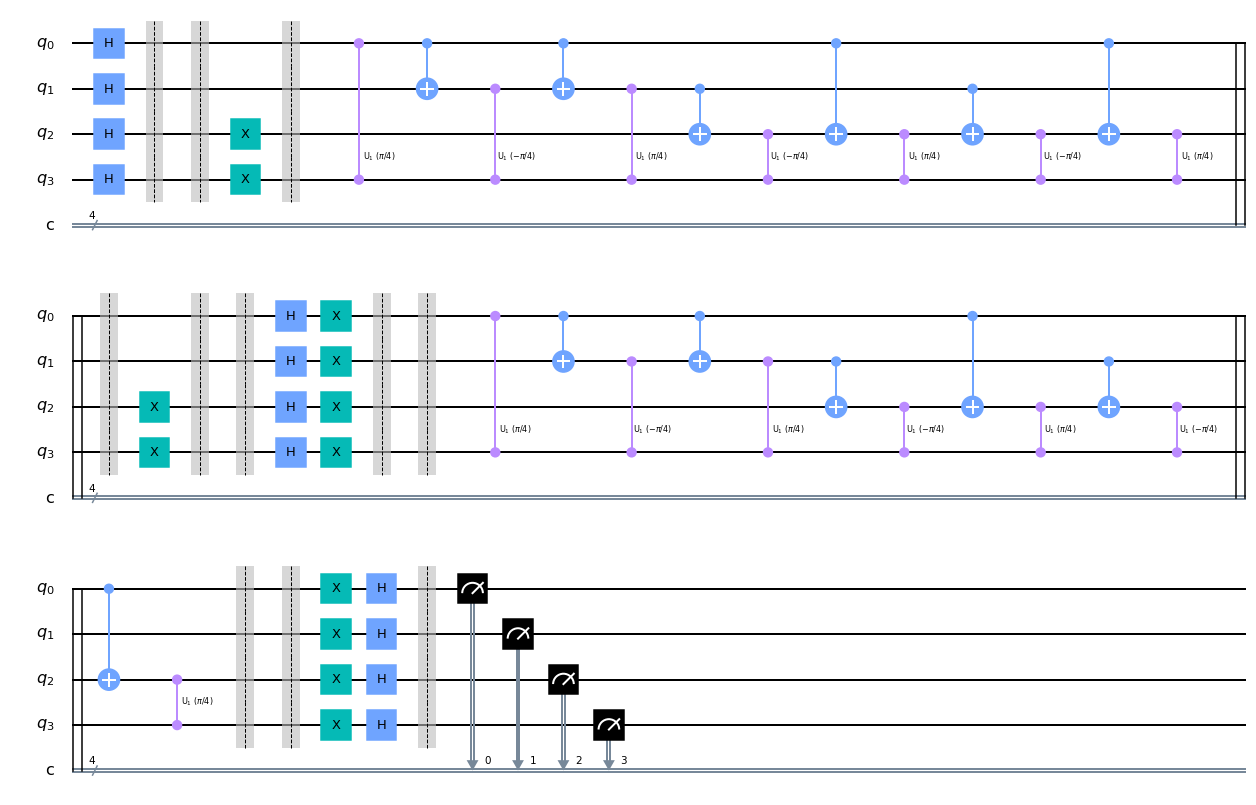

In [11]:
circuit = init + oracle_flipped + amp_flipped + meas

circuit.draw()

In [12]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(circuit, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(circuit)
    
print(counts)    

{'0000': 21, '0001': 37, '0010': 27, '0011': 496, '0100': 37, '0101': 35, '0110': 45, '0111': 28, '1000': 36, '1001': 45, '1010': 32, '1011': 36, '1100': 34, '1101': 35, '1110': 41, '1111': 39}


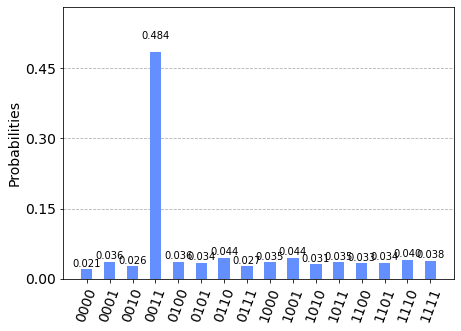

In [13]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [405]:
sv_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(circuit, sv_sim)
statevec = job_sim.result().get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

# Double Application of the Oracle and Amplification <a class="anchor" id="4qubitdouble"></a>

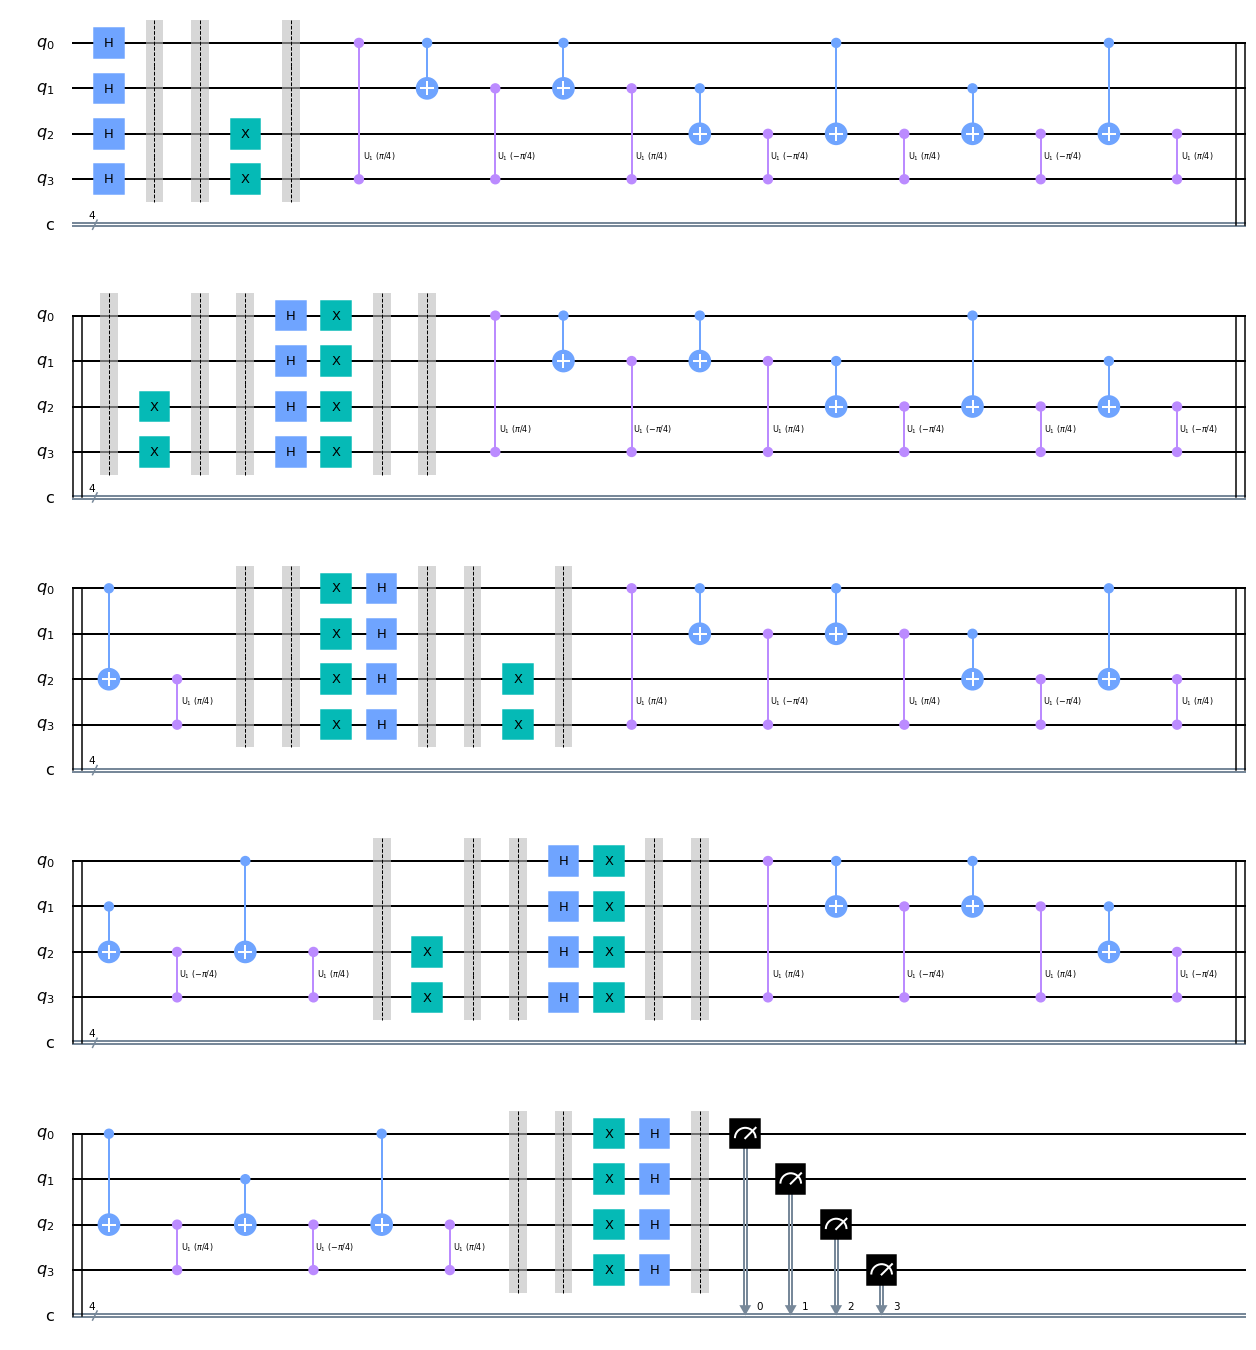

In [16]:
circuit2 = init + ( oracle_flipped + amp_flipped ) + ( oracle_flipped + amp_flipped ) + meas

circuit2.draw()

In [17]:
job_sim2 = execute(circuit2, backend_sim, shots=1024)

# Grab the results from the job.
result_sim2 = job_sim2.result()
counts2 = result_sim2.get_counts(circuit2)
    
print(counts2)   

{'0000': 6, '0001': 8, '0010': 8, '0011': 934, '0100': 7, '0101': 9, '0110': 4, '0111': 6, '1000': 6, '1001': 7, '1010': 5, '1011': 8, '1100': 3, '1101': 1, '1110': 6, '1111': 6}


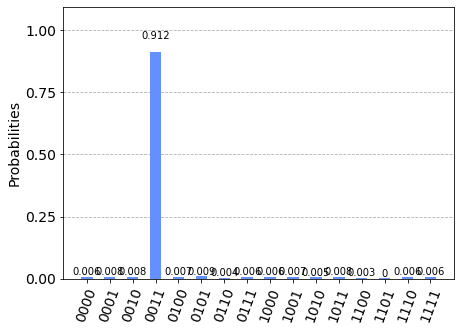

In [24]:
from qiskit.visualization import plot_histogram
plot_histogram(counts2)

# Grover Algorithm for Many-Qubit Systems <a class="anchor" id="many_qubit"></a>

## Many-Qubit controlled Z-Gate <a class="anchor" id="many_zgate"></a>

In [95]:
def controlled_nz(number_qubits):
    
    import math

    
    cnz = QuantumCircuit(number_qubits)
    phi = math.pi / ( 2 ** (number_qubits - 2))
    qmax = number_qubits-1

    ######################## 2 Qubits #############################
    
    cnz.barrier()

    cnz.cu1(phi, 0, qmax )

    cnz.barrier()
    
    ######################## 3 Qubits #############################
    
    if number_qubits >= 3:
        cont = 1    
        addition = 0

        cnz.cx(addition,cont)
        cnz.cu1(-phi, cont, qmax )
        ##### Copied ##### 
        cnz.cx(addition,cont)
        cnz.cu1(phi, cont, qmax)

        cnz.barrier()
        
    ######################## 4 Qubits #############################
    
        if number_qubits >= 4:
            cont = 2    
            addition = 1


            cnz.cx(addition,cont)      ### New variable
            cnz.cu1(-phi, cont, qmax )
            cnz.cx(0,cont)
            cnz.cu1(phi, cont, qmax)
            ##### Copied ##### 
            cnz.cx(addition,cont)      ### New variable
            cnz.cu1(-phi, cont, qmax )
            cnz.cx(0,cont)
            cnz.cu1(phi, cont, qmax)

            cnz.barrier()
        
    ######################## Function for more Qubtis #############################
    
    #The following function defines the sequence for number of different qubits used
    # "Minus ein die länge der liste plus plus 11 und das letzte plus 10, dann kopieren"
    
    l = [1,1]
    
    out = l 
    for j in range(3,number_qubits-1):
        
        for i in range(0,len(out)-1):

            out[i] += 1
        
        out = out + out
        
        # out beinhaltet in diesem Schritt die reihenfolge der cnx gates
        # zwischen diesen muss jeweils die gate sequenz kommen:
        #    cnz.cx(out[?], cont)
        #    cnz.cu1(-phi, cont, qmax )
        #    cnz.cx(0,cont)
        #    cnz.cu1(phi, cont, qmax)
        # cont ist dabei das Target unit,
        
        for k in out:
            #print(k,j)
            cnz.cx(k, j)
            cnz.cu1(-phi, j, qmax )
            cnz.cx(0,j)
            cnz.cu1(phi, j, qmax)
            
        cnz.barrier()
        
        #print(out)    
        
        
    return cnz

In [45]:
search_pattern = "010010"
circ_length = len(search_pattern)
init = QuantumCircuit(circ_length)
hadamard = QuantumCircuit(circ_length)
for i in range(0,circ_length):
    
    hadamard.h(i)
    hadamard.x(i)

cnz = controlled_nz(circ_length)

meas = QuantumCircuit(circ_length,circ_length)
meas.measure(range(circ_length),range(circ_length))

circuit = init + hadamard + cnz + hadamard + meas
    
#circuit.draw()

{'000001': 3, '010000': 1, '010001': 2, '010010': 9, '010011': 2, '010110': 1, '010111': 1, '011000': 1, '011001': 1, '011010': 2, '011100': 1, '011101': 3, '011110': 1, '011111': 4, '000010': 3, '100000': 1, '100001': 1, '100010': 2, '100100': 1, '100101': 3, '100110': 2, '100111': 1, '101000': 3, '101001': 4, '101010': 2, '101011': 1, '101100': 1, '101101': 1, '101111': 1, '000011': 1, '110000': 3, '110001': 1, '110100': 2, '110101': 1, '110110': 2, '110111': 2, '111000': 3, '111001': 2, '111011': 2, '111100': 1, '111101': 1, '111110': 1, '000100': 2, '000101': 1, '000110': 1, '000111': 1, '001001': 4, '001010': 2, '001011': 3, '001100': 2, '001101': 2, '001111': 1} <qiskit.result.result.Result object at 0x7fd48ba0a1d0>


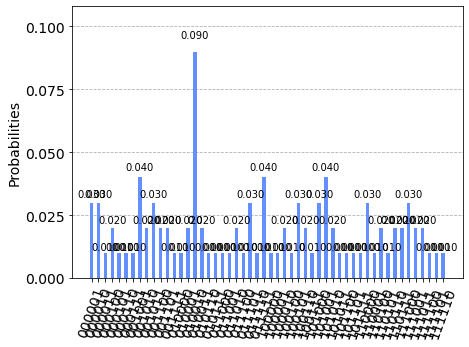

In [402]:
from qiskit.visualization import plot_histogram
 
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(circuit, backend_sim, shots=100)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(circuit)

print(counts, result_sim)
plot_histogram(counts)

## Many Qubit Grover Circuit <a class="anchor" id="many_circuit"></a>

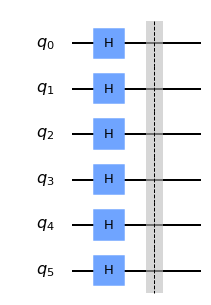

In [47]:
init = QuantumCircuit(circ_length)

for i in range(circ_length):
    init.h(i)
init.barrier()

init.draw()

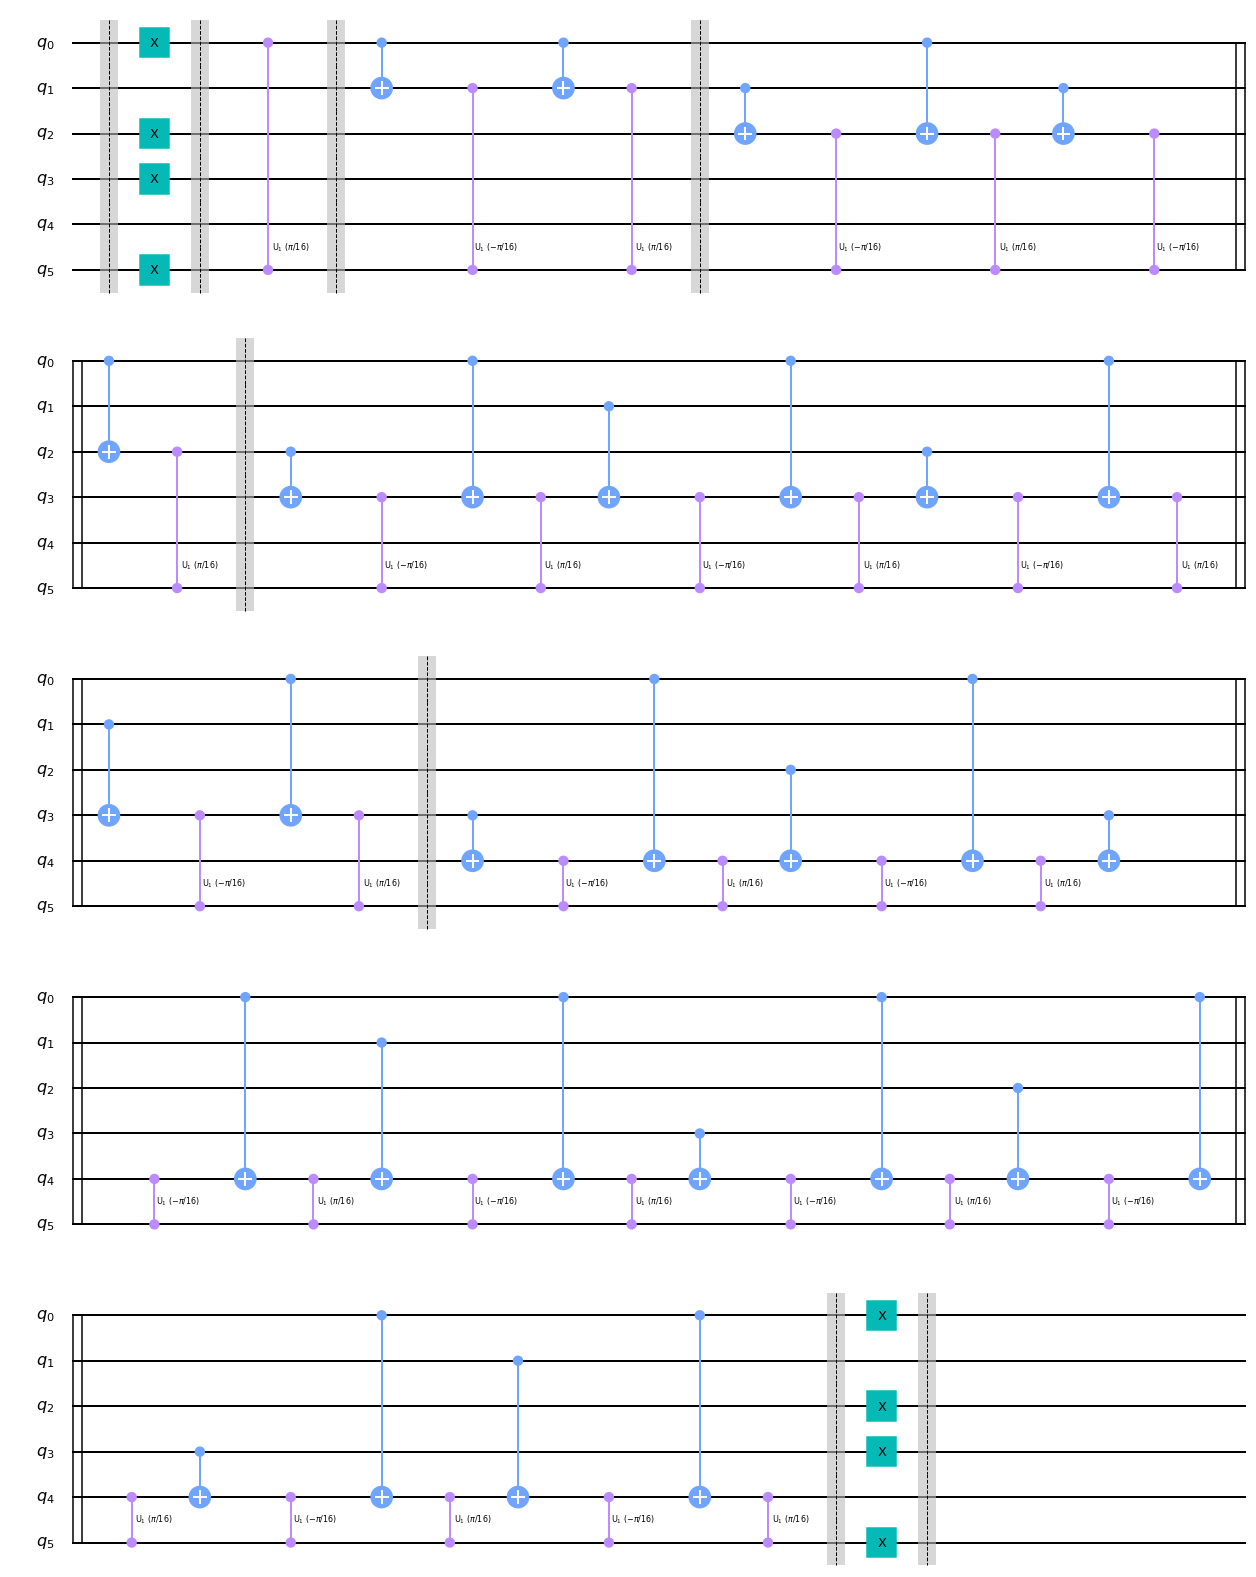

In [57]:
oracle = QuantumCircuit(circ_length)

oracle.barrier()

x_s = -1
for i in search_pattern:
    x_s += 1
    x = int(i)
    if x == 0:
        oracle.x(x_s)
        
cnz = controlled_nz(circ_length)
oracle_flipped = oracle + cnz

x_s = -1
for i in search_pattern:
    x_s += 1
    x = int(i)
    if x == 0:
        oracle_flipped.x(x_s) 


oracle_flipped.barrier()

oracle_flipped.draw()

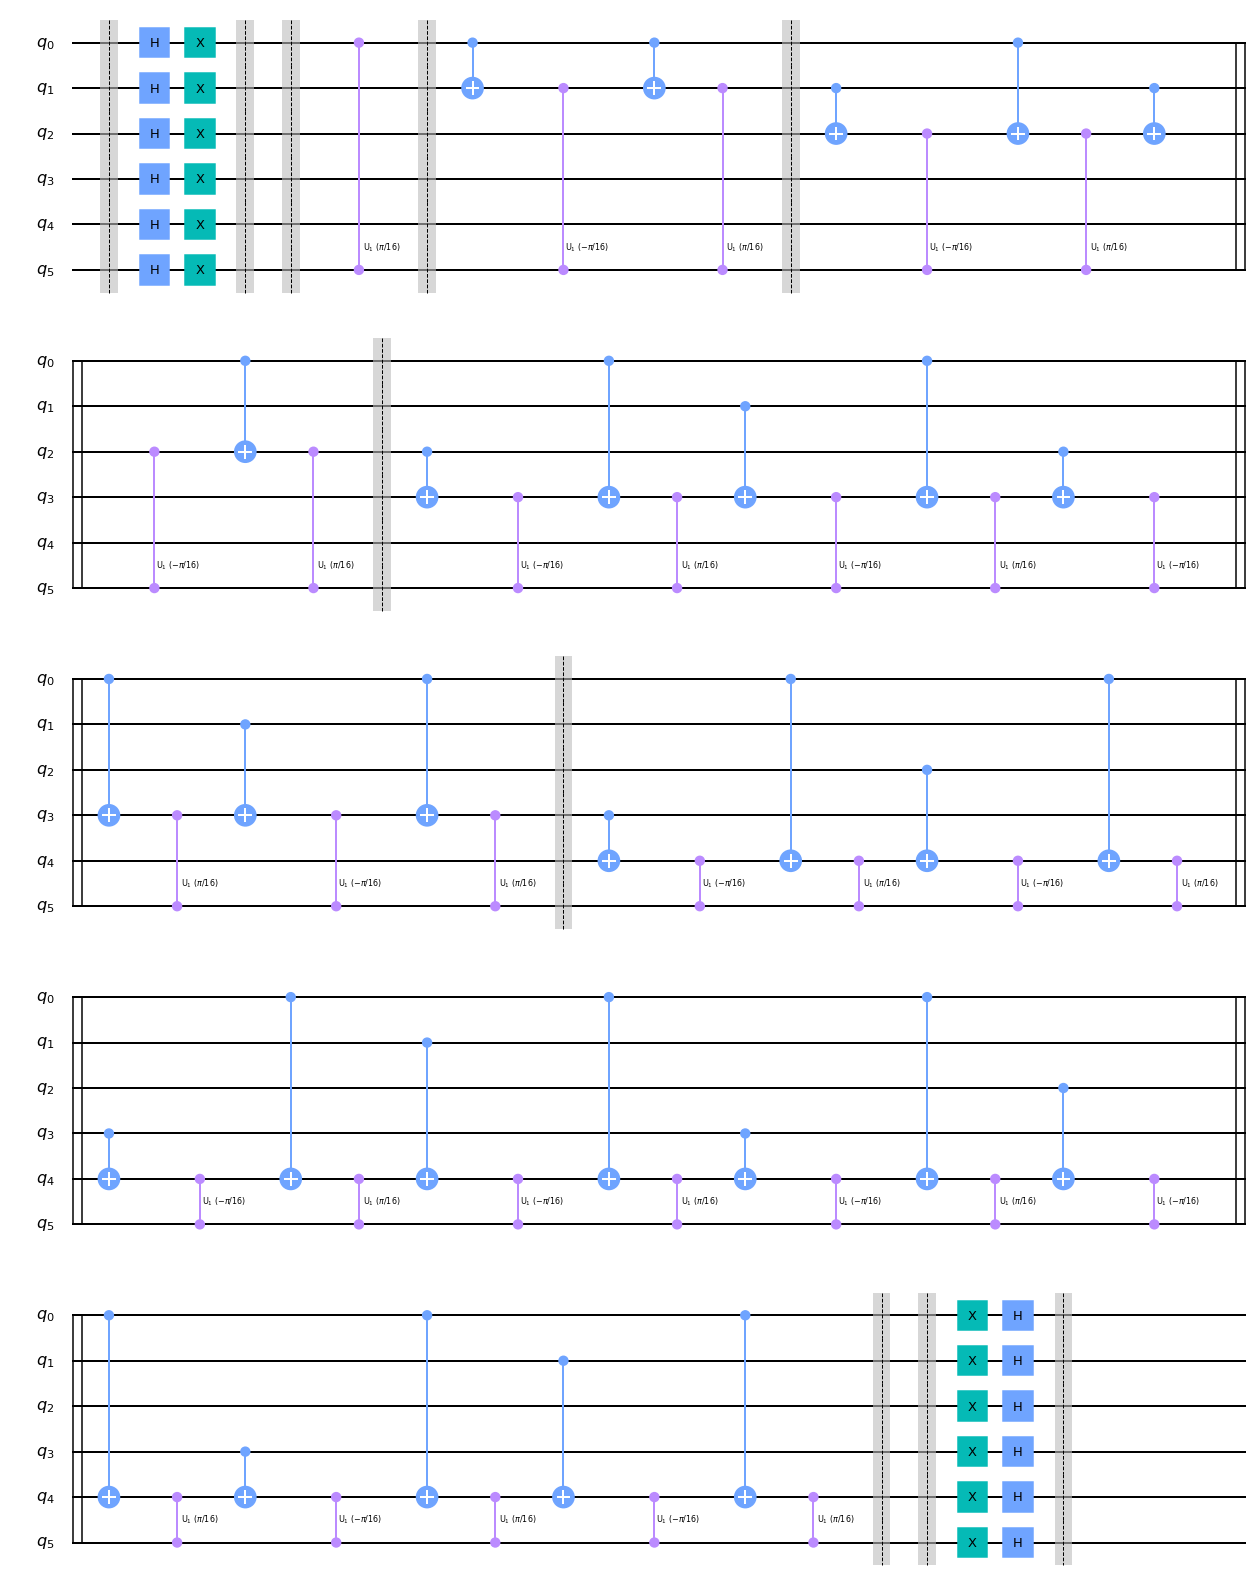

In [58]:
amp = QuantumCircuit(circ_length)

amp.barrier()

for q in range(circ_length):
    amp.h(q)
    amp.x(q)
    
amp.barrier()
    
amp_flipped = amp + cnz

amp_flipped.barrier()

for q in range(circ_length):
    amp_flipped.x(q)
    amp_flipped.h(q)
      
amp_flipped.barrier()

amp_flipped.draw()

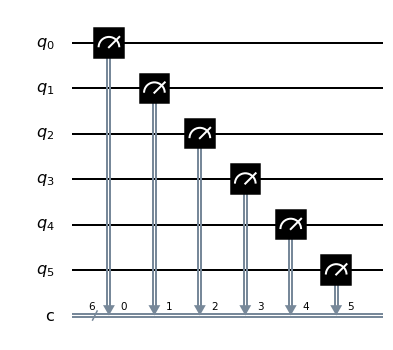

In [50]:
meas = QuantumCircuit(circ_length,circ_length)

meas.measure(range(circ_length),range(circ_length))

meas.draw()

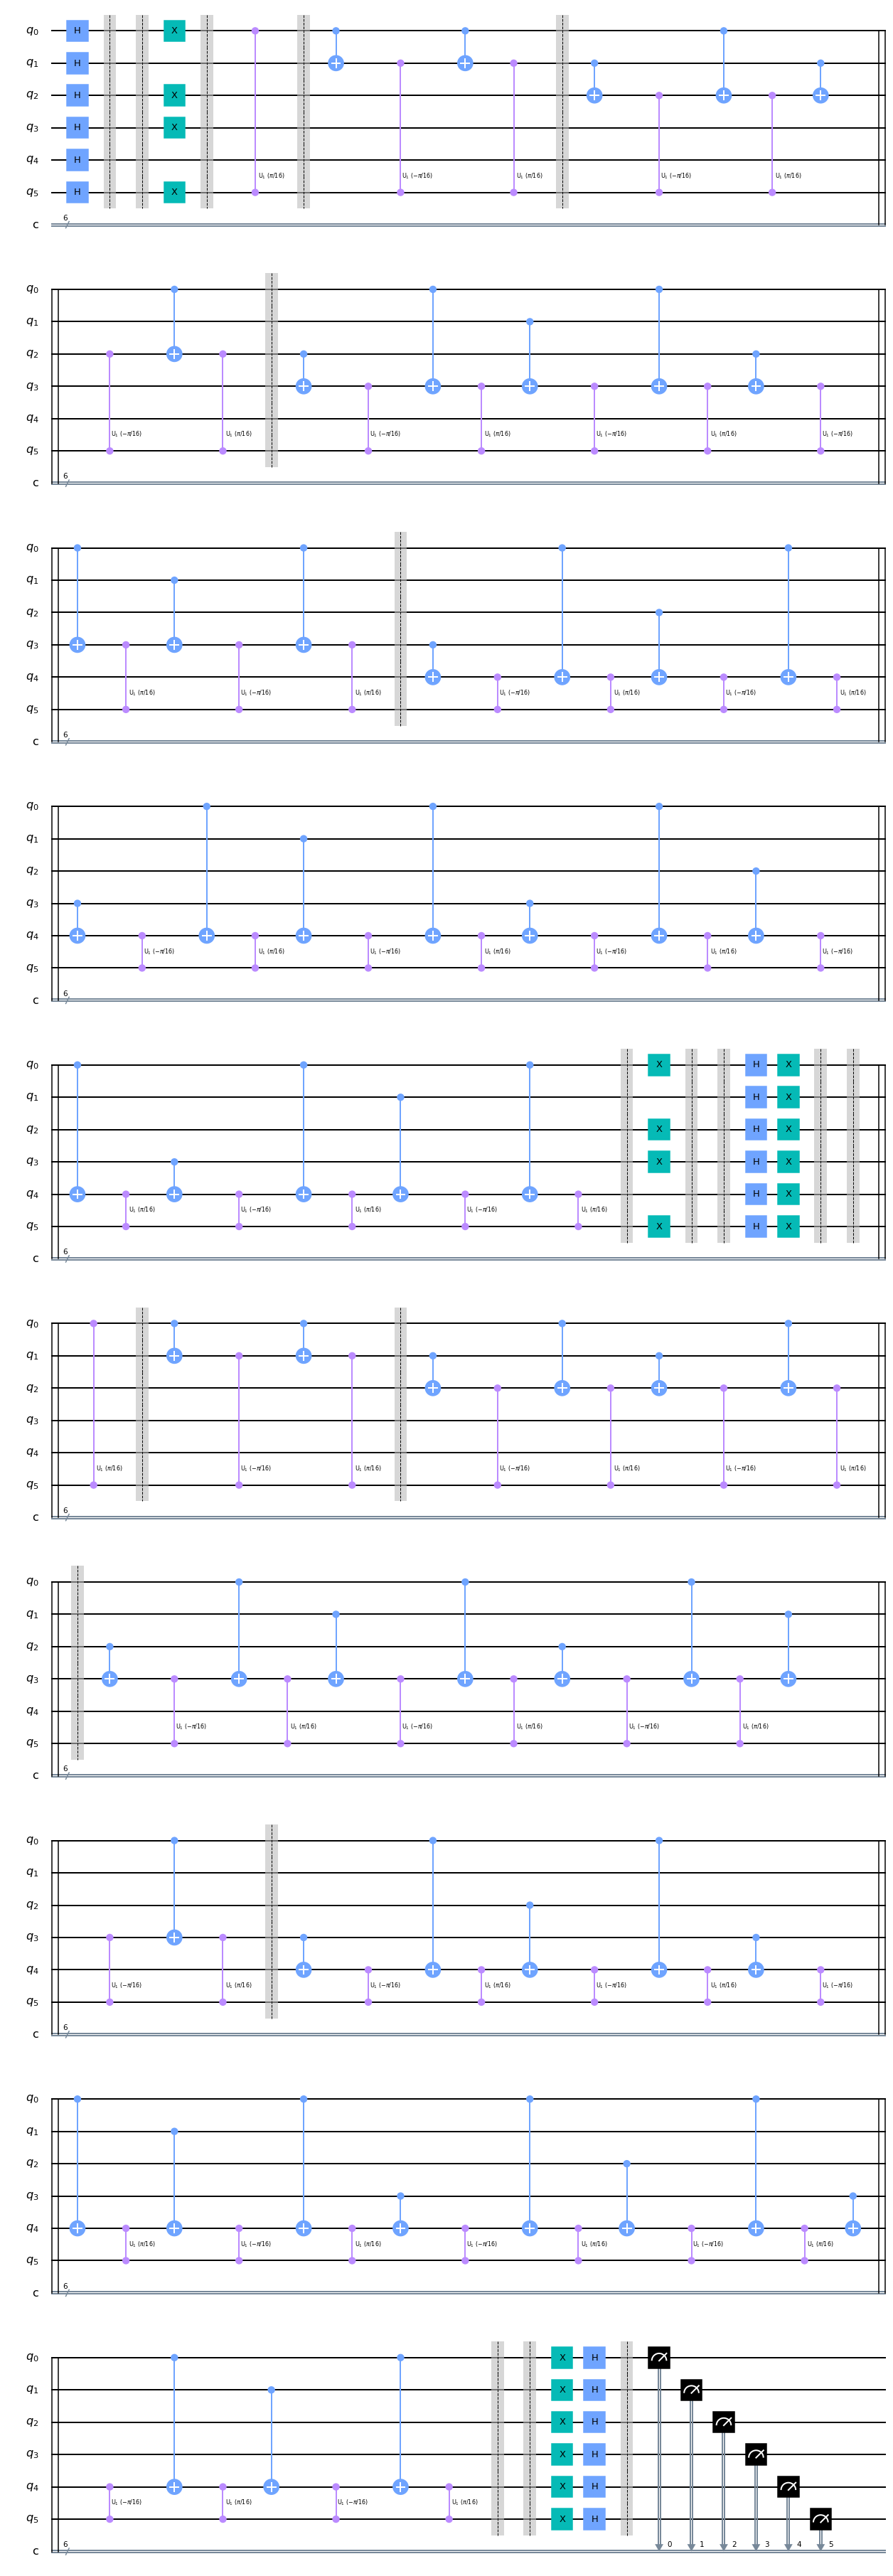

In [59]:
circuit = init + oracle_flipped + amp_flipped + meas

circuit.draw()

In [62]:
from qiskit.visualization import plot_histogram
 
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('bogota')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(circuit, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(circuit)

print(counts, result_sim)

{'000000': 13, '000001': 15, '010000': 13, '010001': 17, '010010': 145, '010011': 17, '010100': 7, '010101': 15, '010110': 12, '010111': 16, '011000': 19, '011001': 14, '011010': 17, '011011': 10, '011100': 12, '011101': 17, '011110': 8, '011111': 12, '000010': 12, '100000': 18, '100001': 14, '100010': 15, '100011': 16, '100100': 14, '100101': 8, '100110': 18, '100111': 11, '101000': 16, '101001': 11, '101010': 16, '101011': 9, '101100': 16, '101101': 12, '101110': 16, '101111': 16, '000011': 11, '110000': 10, '110001': 17, '110010': 12, '110011': 10, '110100': 14, '110101': 15, '110110': 13, '110111': 15, '111000': 18, '111001': 14, '111010': 12, '111011': 10, '111100': 16, '111101': 6, '111110': 20, '111111': 14, '000100': 13, '000101': 18, '000110': 17, '000111': 19, '001000': 11, '001001': 14, '001010': 18, '001011': 9, '001100': 18, '001101': 18, '001110': 12, '001111': 13} <qiskit.result.result.Result object at 0x7fd48b9caed0>


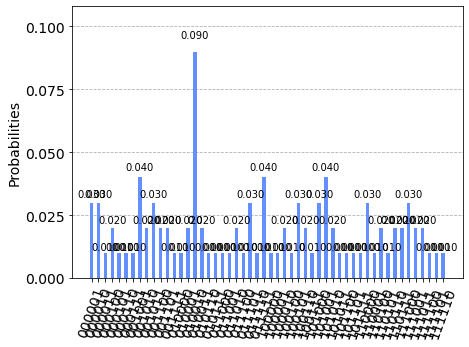

In [403]:
plot_histogram(counts)

## Many Qubit Grover Function <a class="anchor" id="many_qubit_func"></a>

### Simulation

In [93]:
def grover_nqubits_sim(circ_length, search_pattern):
    
    search_pattern = str(search_pattern)
    
    ##################################
    
    init = QuantumCircuit(circ_length)

    for i in range(circ_length):
        init.h(i)
    init.barrier()
    
    ####################################
    
    oracle = QuantumCircuit(circ_length)

    oracle.barrier()
    x_s = -1
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle.x(x_s)

    cnz = controlled_nz(circ_length)
    oracle_flipped = oracle + cnz

    x_s = -1
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle_flipped.x(x_s) 
    oracle_flipped.barrier()
    
    ####################################
    
    amp = QuantumCircuit(circ_length)

    amp.barrier()
    for q in range(circ_length):
        amp.h(q)
        amp.x(q)

    amp.barrier()
    amp_flipped = amp + cnz
    amp_flipped.barrier()
    for q in range(circ_length):
        amp_flipped.x(q)
        amp_flipped.h(q)
        
    amp_flipped.barrier()
    
    ####################################
    
    meas = QuantumCircuit(circ_length,circ_length)

    meas.measure(range(circ_length),range(circ_length))
    
    ####################################
    
    circuit = init + oracle_flipped + amp_flipped + meas
    
    from qiskit.visualization import plot_histogram
 
    # Use Aer's qasm_simulator
    backend_sim = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job_sim = execute(circuit, backend_sim, shots=1024)

    # Grab the results from the job.
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circuit)

    
    return counts

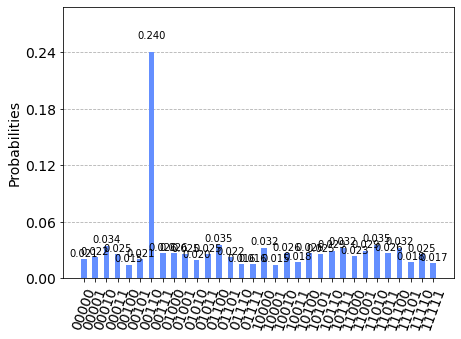

In [454]:
counts = grover_nqubits_sim(5,"01100")

from qiskit.visualization import plot_histogram
plot_histogram(counts)

### Real Device

In [48]:
def grover_nqubits_device(circ_length, search_pattern):
    
    search_pattern = str(search_pattern)
    
    ##################################
    
    init = QuantumCircuit(circ_length)

    for i in range(circ_length):
        init.h(i)
    init.barrier()
    
    ####################################
    
    oracle = QuantumCircuit(circ_length)

    oracle.barrier()
    x_s = -1
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle.x(x_s)

    cnz = controlled_nz(circ_length)
    oracle_flipped = oracle + cnz

    x_s = -1
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle_flipped.x(x_s) 
    oracle_flipped.barrier()
    
    ####################################
    
    amp = QuantumCircuit(circ_length)

    amp.barrier()
    for q in range(circ_length):
        amp.h(q)
        amp.x(q)

    amp.barrier()
    amp_flipped = amp + cnz
    amp_flipped.barrier()
    for q in range(circ_length):
        amp_flipped.x(q)
        amp_flipped.h(q)
        
    amp_flipped.barrier()
    
    ####################################
    
    meas = QuantumCircuit(circ_length,circ_length)

    meas.measure(range(circ_length),range(circ_length))
    
    ####################################
    
    circuit = init + oracle_flipped + amp_flipped + meas
    
    from qiskit.visualization import plot_histogram
    from qiskit.tools.monitor import job_monitor

    # set the right provider and backend
    provider=IBMQ.get_provider(hub='ibm-q-education', group='tum-filipp-su20', project='ph2299')

    backend=provider.get_backend('ibmq_bogota')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job = execute(circuit, backend, shots=1024)
    job_monitor(job)

    # Grab the results from the job.
    result = job.result()
    counts = result.get_counts(circuit)

    
    return counts

Job Status: job has successfully run


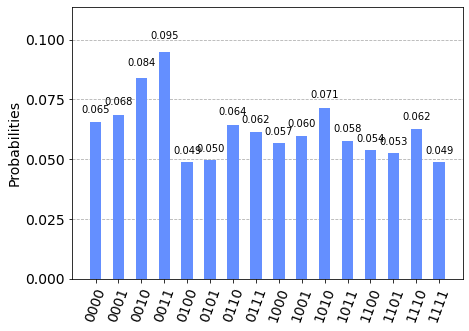

In [467]:
counts = grover_nqubits_device(4,"1100")

from qiskit.visualization import plot_histogram
plot_histogram(counts)

## Do we need to apply the oracle more often?

In [153]:
def grover_nqubits_device_4qubit(circ_length, search_pattern):
    
    search_pattern = str(search_pattern)
    
    ##################################
    
    init = QuantumCircuit(circ_length)

    for i in range(circ_length):
        init.h(i)
    init.barrier()
    
    ####################################
    
    oracle = QuantumCircuit(circ_length)

    oracle.barrier()
    x_s = -1
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle.x(x_s)

    cnz = controlled_nz(circ_length)
    oracle_flipped = oracle + cnz

    x_s = -1
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle_flipped.x(x_s) 
    oracle_flipped.barrier()
    
    ####################################
    
    amp = QuantumCircuit(circ_length)

    amp.barrier()
    for q in range(circ_length):
        amp.h(q)
        amp.x(q)

    amp.barrier()
    amp_flipped = amp + cnz
    amp_flipped.barrier()
    for q in range(circ_length):
        amp_flipped.x(q)
        amp_flipped.h(q)
        
    amp_flipped.barrier()
    
    ####################################
    
    meas = QuantumCircuit(circ_length,circ_length)

    meas.measure(range(circ_length),range(circ_length))
    
    ####################################
    
    circuit = init + ( oracle_flipped + amp_flipped ) + ( oracle_flipped + amp_flipped ) + ( oracle_flipped + amp_flipped ) + meas
    
    from qiskit.visualization import plot_histogram
    from qiskit.tools.monitor import job_monitor

    # set the right provider and backend
    provider=IBMQ.get_provider(hub='ibm-q-education', group='tum-filipp-su20', project='ph2299')

    backend=provider.get_backend('ibmq_rome')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job = execute(circuit, backend, shots=4048)
    job_monitor(job)

    # Grab the results from the job.
    result = job.result()
    counts = result.get_counts(circuit)

    
    return counts

Job Status: job has successfully run


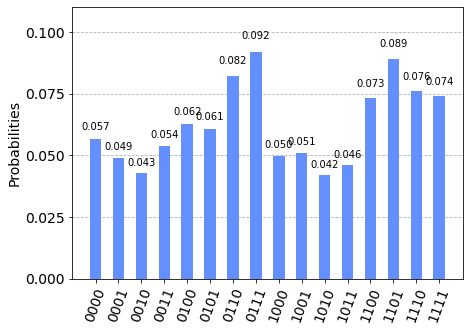

In [51]:
counts = grover_nqubits_device_4qubit(4,"1100")

from qiskit.visualization import plot_histogram
plot_histogram(counts)

# Number of Oracle and Amplification Apllications and Search Pattern Amplitude <a class="anchor" id="num_oracle_amp"></a>

In [99]:
def grover_nqubits_multible(circ_length, search_pattern, number_of_oracle_amp, shots):
    
    search_pattern = str(search_pattern)
    
    ##################################
    
    init = QuantumCircuit(circ_length)

    for i in range(circ_length):
        init.h(i)
    init.barrier()
    
    ####################################
    
    oracle = QuantumCircuit(circ_length)

    oracle.barrier()
    x_s = 0
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle.x(circ_length-x_s)

    cnz = controlled_nz(circ_length)
    oracle_flipped = oracle + cnz

    x_s = 0
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle_flipped.x(circ_length-x_s) 
    oracle_flipped.barrier()
    
    ####################################
    
    amp = QuantumCircuit(circ_length)

    amp.barrier()
    for q in range(circ_length):
        amp.h(q)
        amp.x(q)

    amp.barrier()
    amp_flipped = amp + cnz
    amp_flipped.barrier()
    for q in range(circ_length):
        amp_flipped.x(q)
        amp_flipped.h(q)
        
    amp_flipped.barrier()
    
    ####################################
    
    meas = QuantumCircuit(circ_length,circ_length)

    meas.measure(range(circ_length),range(circ_length))
    
    ####################################
    
    circuit = init 
    
    for i in range(0,number_of_oracle_amp):
        
        circuit = circuit  + oracle_flipped + amp_flipped
    
    circuit = circuit + meas
    
    from qiskit.visualization import plot_histogram
 
    # Use Aer's qasm_simulator
    backend_sim = Aer.get_backend('qasm_simulator')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job_sim = execute(circuit, backend_sim, shots=shots)

    # Grab the results from the job.
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circuit)
  
    return counts

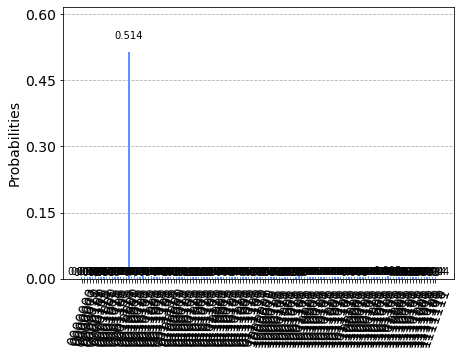

In [53]:
counts = grover_nqubits_multible(7,"0010001",4,10000)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [184]:
func_num = 13
shots = 10000
permax = []
for i in range(1,func_num):
    counts = grover_nqubits_multible(4,"0110",i,shots)

    percent_search = int(counts["0110"]) / shots * 100   
    permax.append(percent_search)                               
    

print(permax)           

[47.19, 90.85, 96.04, 58.75, 12.17, 2.12, 36.58, 83.82, 99.14, 69.58, 20.66, 0.1]


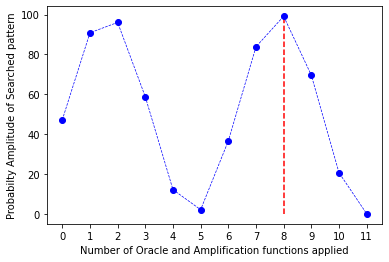

In [187]:
import matplotlib.pyplot as plt
import numpy as np

maxposition = permax.index(max(permax))

plt.plot(permax, 'bo--', lw=0.7)
plt.ylabel('Probabilty Amplitude of Searched pattern')
plt.xlabel('Number of Oracle and Amplification functions applied')
plt.xticks(np.arange(0,func_num, 1))
plt.vlines(maxposition,0,permax[maxposition], ls='--', color='r')
plt.show()

In [55]:
def grover_nqubits_multible_amplitude(circ_length, search_pattern, func_num, shots):
    
    permax = []
    for i in range(1,func_num):
        counts = grover_nqubits_multible(circ_length, search_pattern, i, shots)
        #counts[search_pattern] += 1

        if search_pattern in counts:
        
            percent_search = int(counts[search_pattern]) / shots * 100   
            permax.append(percent_search)
        
        else:
            counts[search_pattern] = 0
            percent_search = int(counts[search_pattern]) / shots * 100   
            permax.append(percent_search)
    
    maxposition = permax.index(max(permax))

    
    
    plt.plot(permax, 'bo--', lw=0.7)
    plt.ylabel('Probabilty Amplitude of Searched pattern')
    plt.xlabel('Number of Oracle and Amplification functions applied')
    plt.xticks(np.arange(0,func_num, 1))
    plt.vlines(maxposition,0,permax[maxposition], ls='--', color='r')
    plt.show()
    
    return maxposition

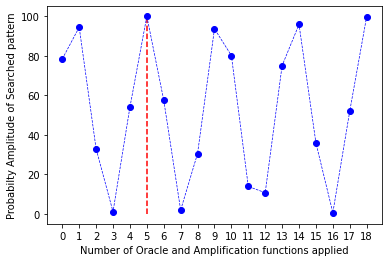

5

In [339]:
grover_nqubits_multible_amplitude(3,"010",20,10000)

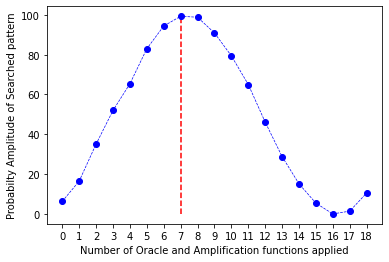

7

In [373]:
grover_nqubits_multible_amplitude(7,"0010001",20,1000)

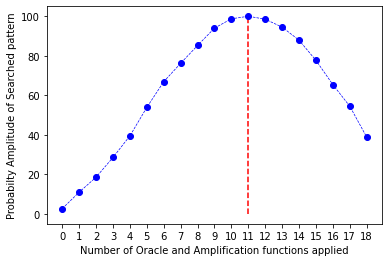

11

In [289]:
grover_nqubits_multible_amplitude(8,"00110001",20,1000)

3 Qubits


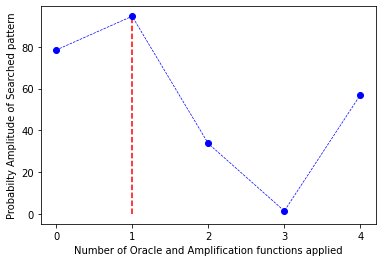

4 Qubits


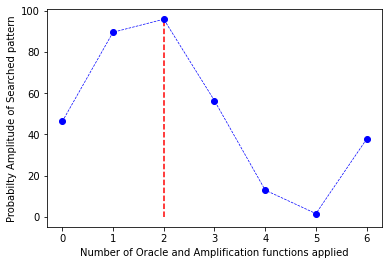

5 Qubits


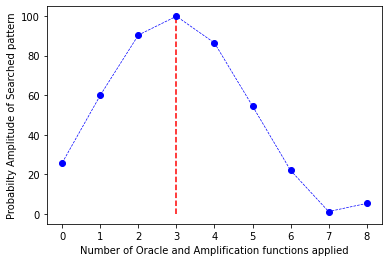

6 Qubits


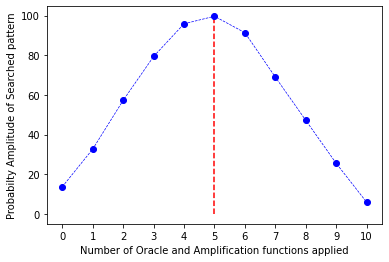

7 Qubits


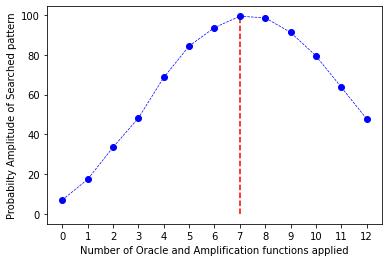

8 Qubits


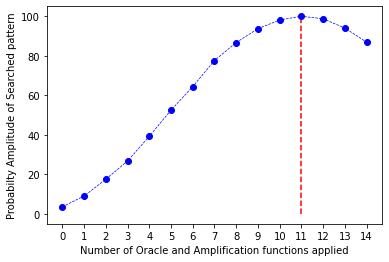

9 Qubits


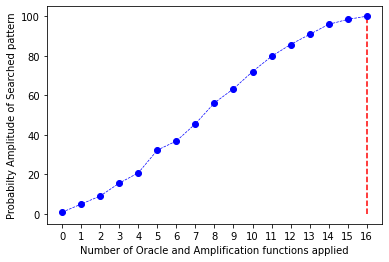

10 Qubits


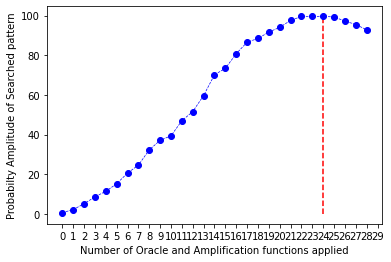

11 Qubits


KeyboardInterrupt: 

In [57]:
liste = []
max_qubits = 20
search_pattern = "010"
for i in range(3,max_qubits):
    print(i, "Qubits")
    if i < 10:
        a = grover_nqubits_multible_amplitude(i,search_pattern,(i*2),1000)
    if i >= 10:
        a = grover_nqubits_multible_amplitude(i,search_pattern,(i*3),1000)
    search_pattern = search_pattern + "1"
    liste.append(a)

liste

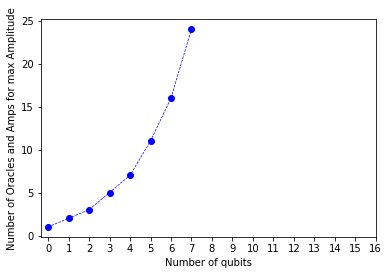

In [58]:
plt.plot(liste, 'bo--', lw=0.7)
plt.ylabel('Number of Oracles and Amps for max Amplitude')
plt.xlabel('Number of qubits')
plt.xticks(np.arange(0,max_qubits-3, 1))
plt.show()

##  Theoretical Predictions of number of necessary Oracles and Amps  <a class="anchor" id="theory_oracles_amps"></a>

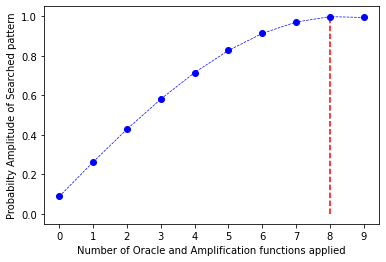

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
circ_length = 7

N = 2 ** circ_length
phi = math.asin( 1 / math.sqrt(N) )

amp_list = []

for t in range(0,10):

    phi_t = ( 2 * t + 1 ) * phi 
    amp = math.sin( phi_t )
    
    amp_list.append(amp)

maxposition_amp = amp_list.index(max(amp_list))


plt.plot(amp_list, 'bo--', lw=0.7)
plt.ylabel('Probabilty Amplitude of Searched pattern')
plt.xlabel('Number of Oracle and Amplification functions applied')
plt.xticks(np.arange(0,10, 1))
plt.vlines(maxposition_amp,0,1, ls='--', color='r')
plt.show()

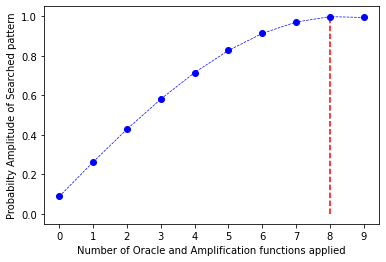

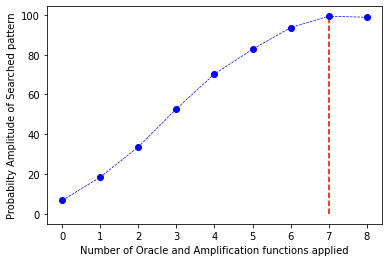

7

In [401]:
circ_length = 7
search_pattern = "001000"

N = 2 ** circ_length
phi = math.asin( 1 / math.sqrt(N) )

amp_list = []

for t in range(0,10):

    phi_t = ( 2 * t + 1 ) * phi 
    amp = math.sin( phi_t )
    
    amp_list.append(amp)

maxposition_amp = amp_list.index(max(amp_list))


plt.plot(amp_list, 'bo--', lw=0.7)
plt.ylabel('Probabilty Amplitude of Searched pattern')
plt.xlabel('Number of Oracle and Amplification functions applied')
plt.xticks(np.arange(0,10, 1))
plt.vlines(maxposition_amp,0,1, ls='--', color='r')
plt.show()

grover_nqubits_multible_amplitude(circ_length,"0011001",10,1000)

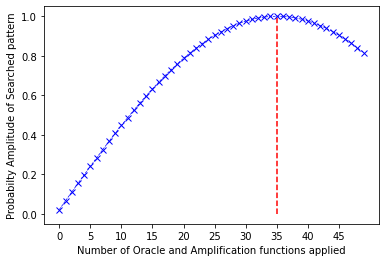

35

In [188]:
circ_length = 11

N = 2 ** circ_length
phi = math.asin( 1 / math.sqrt(N) )

amp_list = []

for t in range(0,50):

    phi_t = ( 2 * t + 1 ) * phi 
    amp = math.sin( phi_t )
    
    amp_list.append(amp)

maxposition_amp = amp_list.index(max(amp_list))


plt.plot(amp_list, 'bx--', lw=0.7)
plt.ylabel('Probabilty Amplitude of Searched pattern')
plt.xlabel('Number of Oracle and Amplification functions applied')
plt.xticks(np.arange(0,50, 5))
plt.vlines(maxposition_amp,0,1, ls='--', color='r')
plt.show()
amp_list.index(max(amp_list))

In [36]:
max_amp = []

for i in range(2,16):
    
    circ_length = i

    N = 2 ** circ_length
    phi = math.asin( 1 / math.sqrt(N) )

    amp_list = [0]

    for t in range(0,1000):

        phi_t = ( 2 * t + 1 ) * phi 
        amp = math.sin( phi_t )       
        
        if amp > amp_list[-1]:

            amp_list.append(amp)

    max_amp.append(amp_list.index(max(amp_list)))

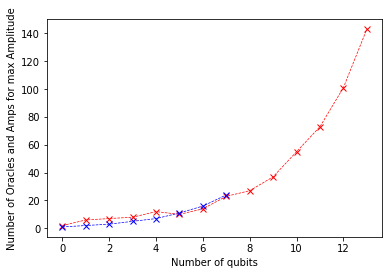

In [103]:
exp = np.logspace(0, 13, base=1.47, num=14)
plt.plot( max_amp, 'rx--' ,liste, 'bx--', lw=0.7) # liste, 'bo--'
plt.ylabel('Number of Oracles and Amps for max Amplitude')
plt.xlabel('Number of qubits')
#plt.xticks(np.arange(0,16, 1),np.arange(3,16, 1))
plt.show()

In [73]:
from ipywidgets import interactive

def f(x):
   
    exp = np.logspace(0, 22, base=x, num=23)
    plt.plot( max_amp, 'rx--',exp, 'kx--' ,lw=0.7) 
    plt.ylabel('Number of Oracles and Amps for max Amplitude')
    plt.xlabel('Number of qubits')
    
    plt.show()

interactive_plot = interactive(f, x=(1,2,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='x', max=2.0, min=1.0, step=0.01), Output()), _dom_cl…

In [140]:
max_amp = []

for i in range(2,25):
    
    circ_length = i

    N = 2 ** circ_length
    phi = math.asin( 1 / math.sqrt(N) )

    amp_list = [0]

    for t in range(0,10000):

        phi_t = ( 2 * t + 1 ) * phi 
        amp = math.sin( phi_t )       
        
        if amp > amp_list[-1]:

            amp_list.append(amp)

    max_amp.append(amp_list.index(max(amp_list)))

In [150]:
def f(x):
    
   
    exp = np.logspace(0, 22, base=x, num=23)
    plt.plot( max_amp, 'rx--',exp, 'kx--' ,lw=0.7) 
    plt.ylabel('Number of Oracles and Amps for max Amplitude')
    plt.xlabel('Number of qubits')
    plt.legend(['Theoretical Data', 'Exponential Function'])
    
    plt.show()

interactive_plot = interactive(f, x=(1.4,1.5,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.45, description='x', max=1.5, min=1.4, step=0.01), Output()), _dom_c…

In [155]:
def f(x,y):
    max_amp = []

    for i in range(2,y):

        circ_length = i

        N = 2 ** circ_length
        phi = math.asin( 1 / math.sqrt(N) )

        amp_list = [0]

        for t in range(0,20000):

            phi_t = ( 2 * t + 1 ) * phi 
            amp = math.sin( phi_t )       

            if amp > amp_list[-1]:

                amp_list.append(amp)

        max_amp.append(amp_list.index(max(amp_list)))

    exp = np.logspace(0, y-3, base=x, num=y-2)
    plt.plot( max_amp, 'rx--',exp, 'kx--' ,lw=0.7) 
    plt.ylabel('Number of Oracles and Amps for max Amplitude')
    plt.xlabel('Number of qubits')
    plt.legend(['Theoretical Data', 'Exponential Function'])
    
    plt.show()

interactive_plot = interactive(f, x=(1.4,1.5,0.01), y=(10,30,1))
interactive_plot

interactive(children=(FloatSlider(value=1.45, description='x', max=1.5, min=1.4, step=0.01), IntSlider(value=2…

In [192]:
def f(y=8):   
    exp = np.logspace(0, y-1, base=1.44, num=y)
    classic = np.logspace(0, y-1, base=2, num=y)
    
    width_in_inches = 12
    height_in_inches = 7
    dots_per_inch = 70

    plt.figure(    figsize=(width_in_inches, height_in_inches),    dpi=dots_per_inch)
    plt.plot( classic/2, 'rx--',exp, 'kx--' ,lw=0.7) 
    plt.ylabel('Number of Oracles and Amps for max Amplitude')
    plt.xlabel('Number of Entries')
    plt.xticks(np.linspace(0,y-1,num=y),np.logspace(0, y-1, base=2, num=y))
    plt.legend(['Classical Search', 'Grover Search'])
    
    if y > 10:
        plt.yscale("log")
    
    plt.show()

interactive_plot = interactive(f,  y=(2,20,1))
interactive_plot

interactive(children=(IntSlider(value=8, description='y', max=20, min=2), Output()), _dom_classes=('widget-int…

##  Testing on Real Devices  <a class="anchor" id="testing"></a>

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import math

In [12]:
states = []

for i in range(0,16):
    
    marked =  [int(x) for x in bin(i)[2:]] 
    
    while len(marked) < 4:
        marked.insert(0,0)
    
    states.append(marked)
print(states)

[[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]]


### Theortical Prediction <a class="anchor" id="testing_theory"></a>

In [119]:
circ_length = 4
t = 3

N = 2 ** circ_length
phi = math.asin( 1 / math.sqrt(N) )

phi_t = ( 2 * t + 1 ) * phi 
amp = math.sin( phi_t )

result = np.ones((16,16)) * (1-amp)/15

for i in range(0,16):
    
    data_i = range(0,16)
    int_list = []
    
    for state in states:
        
        binary_num = ""
        for binary in state:
            
            binary_num += str(binary)
            
        print(binary_num)
            
        integ = int(binary_num, 2)
        
        marked = i#data_i.index(i)
        result[i,i] = amp

0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
0000
0001
0010
0011
0100
0101
0110
0111


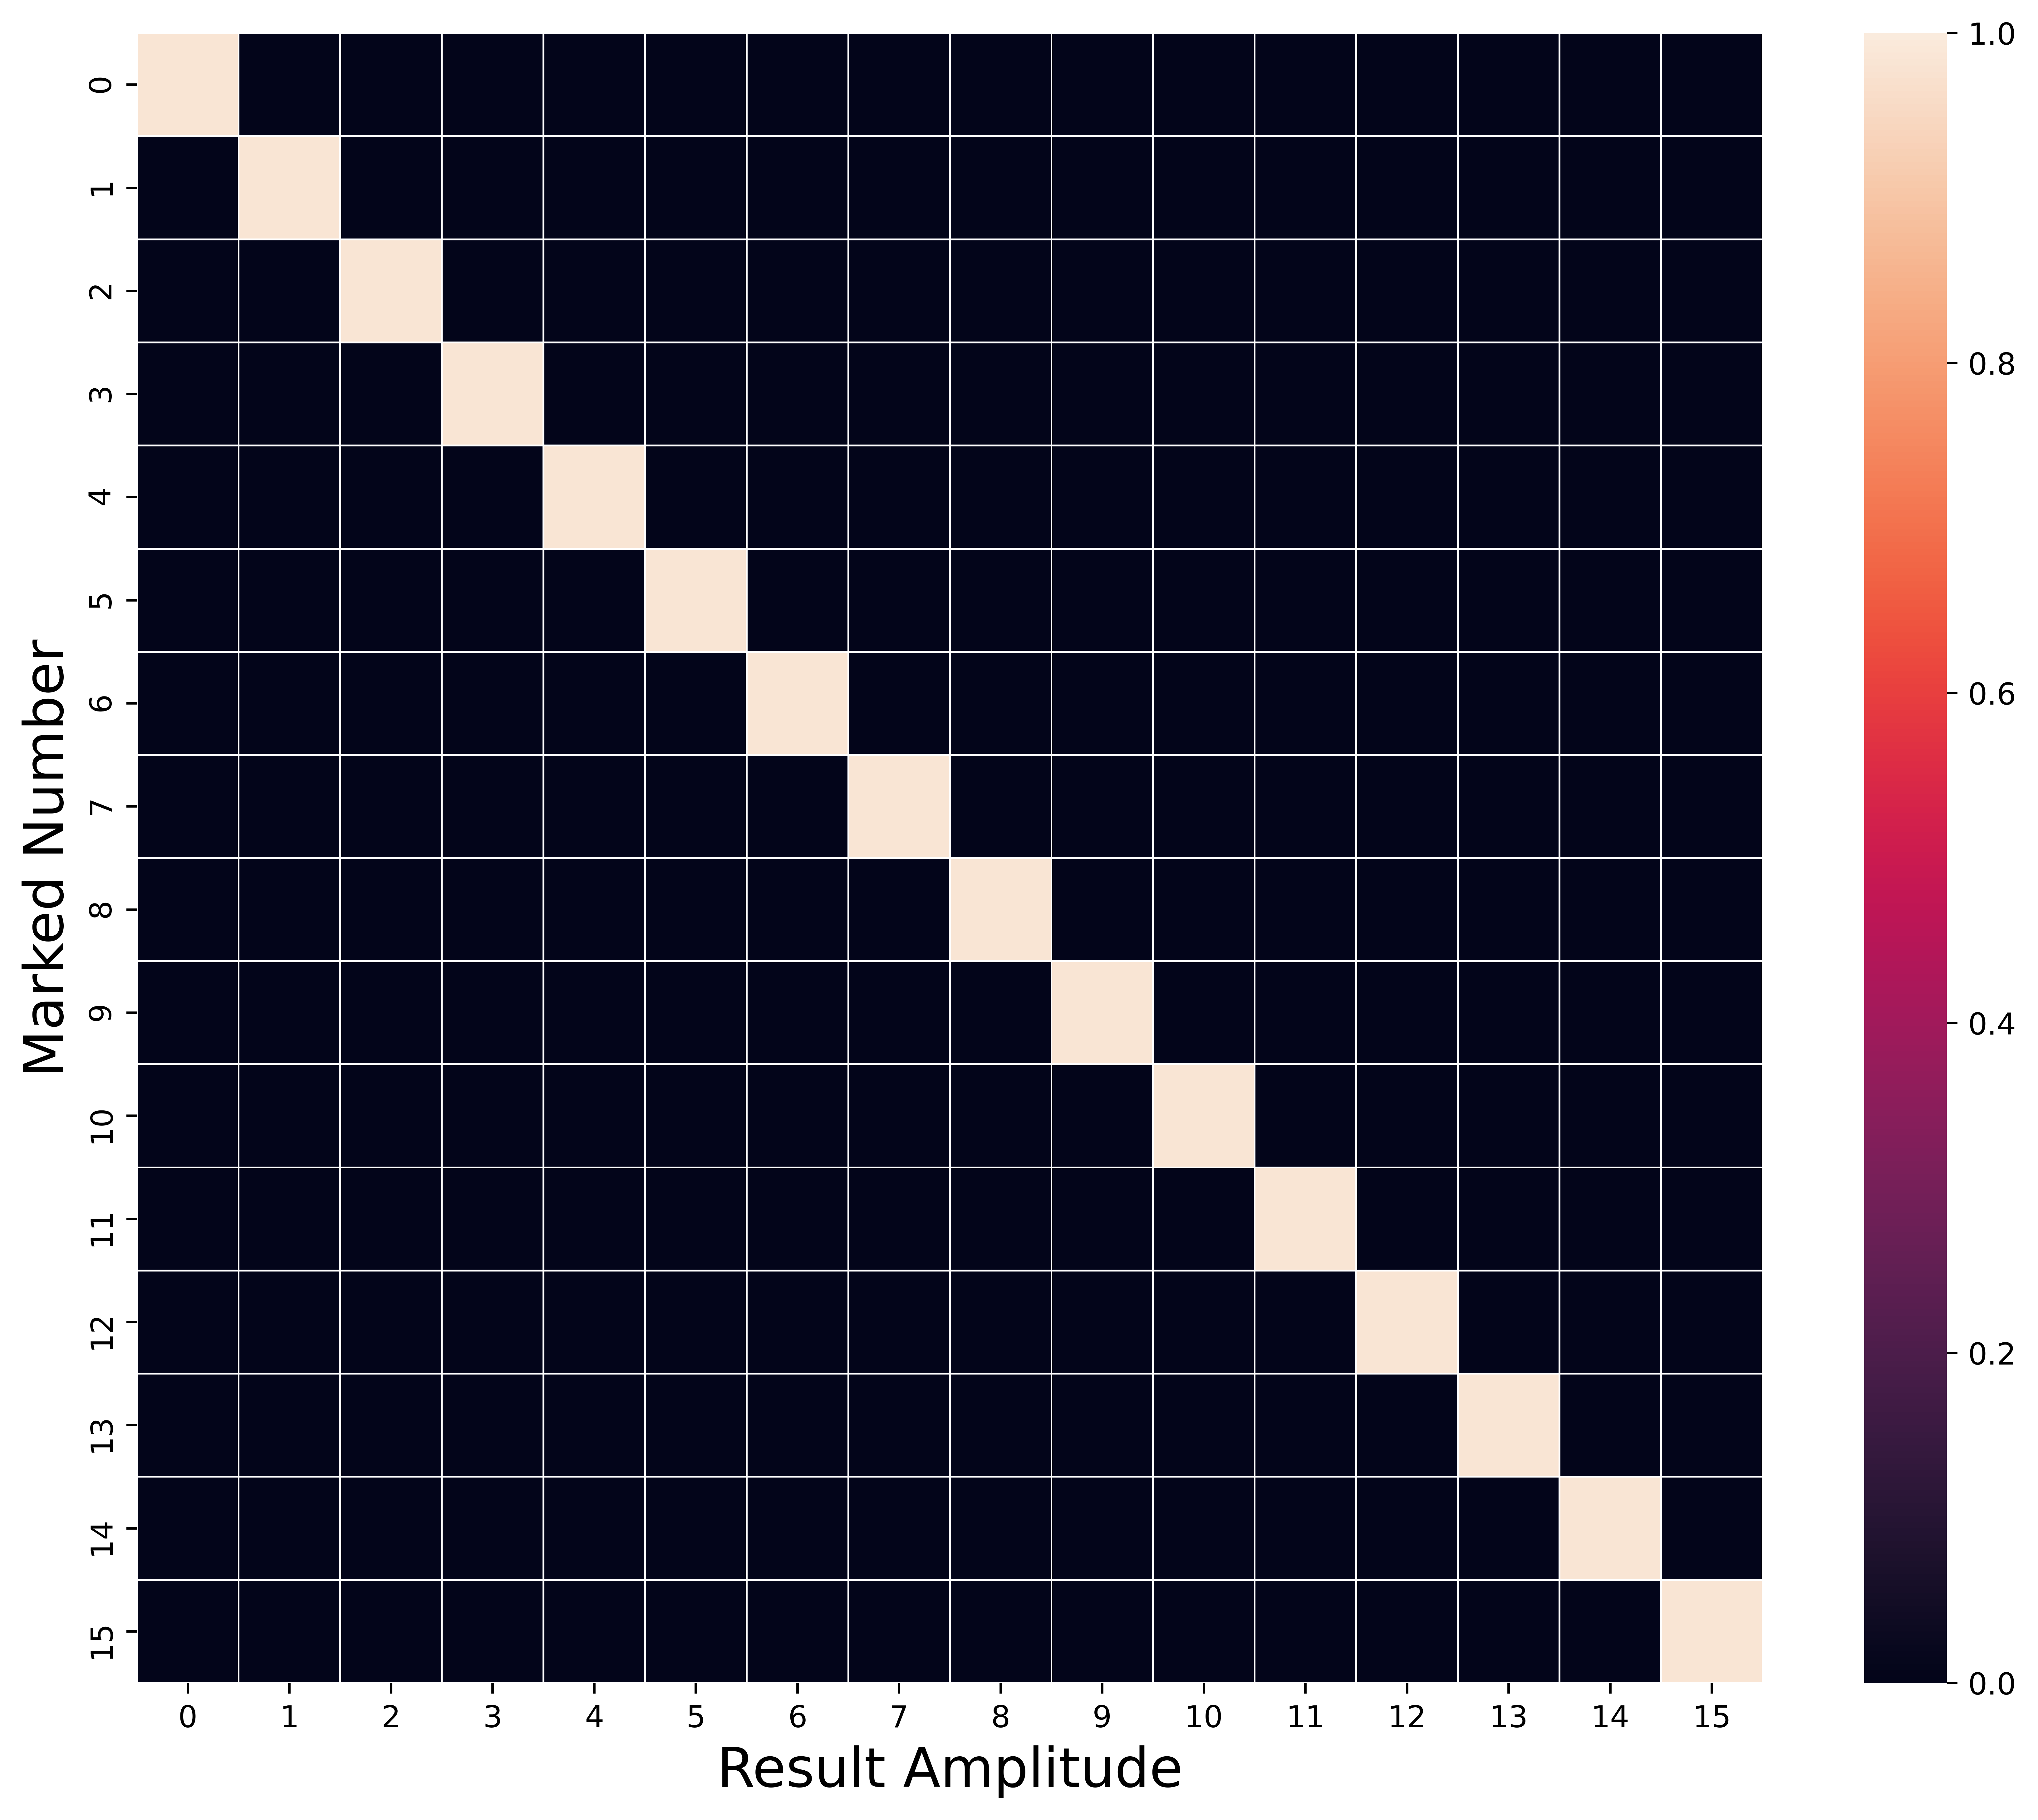

In [120]:
plt.figure(    figsize=(12, 10),    dpi=700)
ax = sns.heatmap(result, linewidth=0.5, vmin = 0, vmax = 1)
plt.ylabel("Marked Number", fontsize=18)
plt.xlabel("Result Amplitude", fontsize=18)
plt.show()

### Simulation <a class="anchor" id="testing_sim"></a>

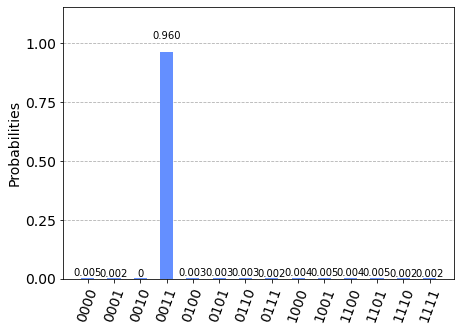

In [121]:
counts = grover_nqubits_multible(4, "0011", 3, 1024)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [148]:
circ_length = 4
t = 3
shots = 40248

result = np.ones((16,16)) * 0.5 #np.zeros((16,16)) 

a = 0
for state in states:
        
    binary_num = ""
    for binary in state:
            
        binary_num += str(binary)
            
    search_pattern = binary_num

    counts = grover_nqubits_multible(circ_length, search_pattern, t, shots)
    
    s = 0
    for key in counts:
    
        res = counts[key]
        result[a,s] = res / shots
        s += 1
    a += 1

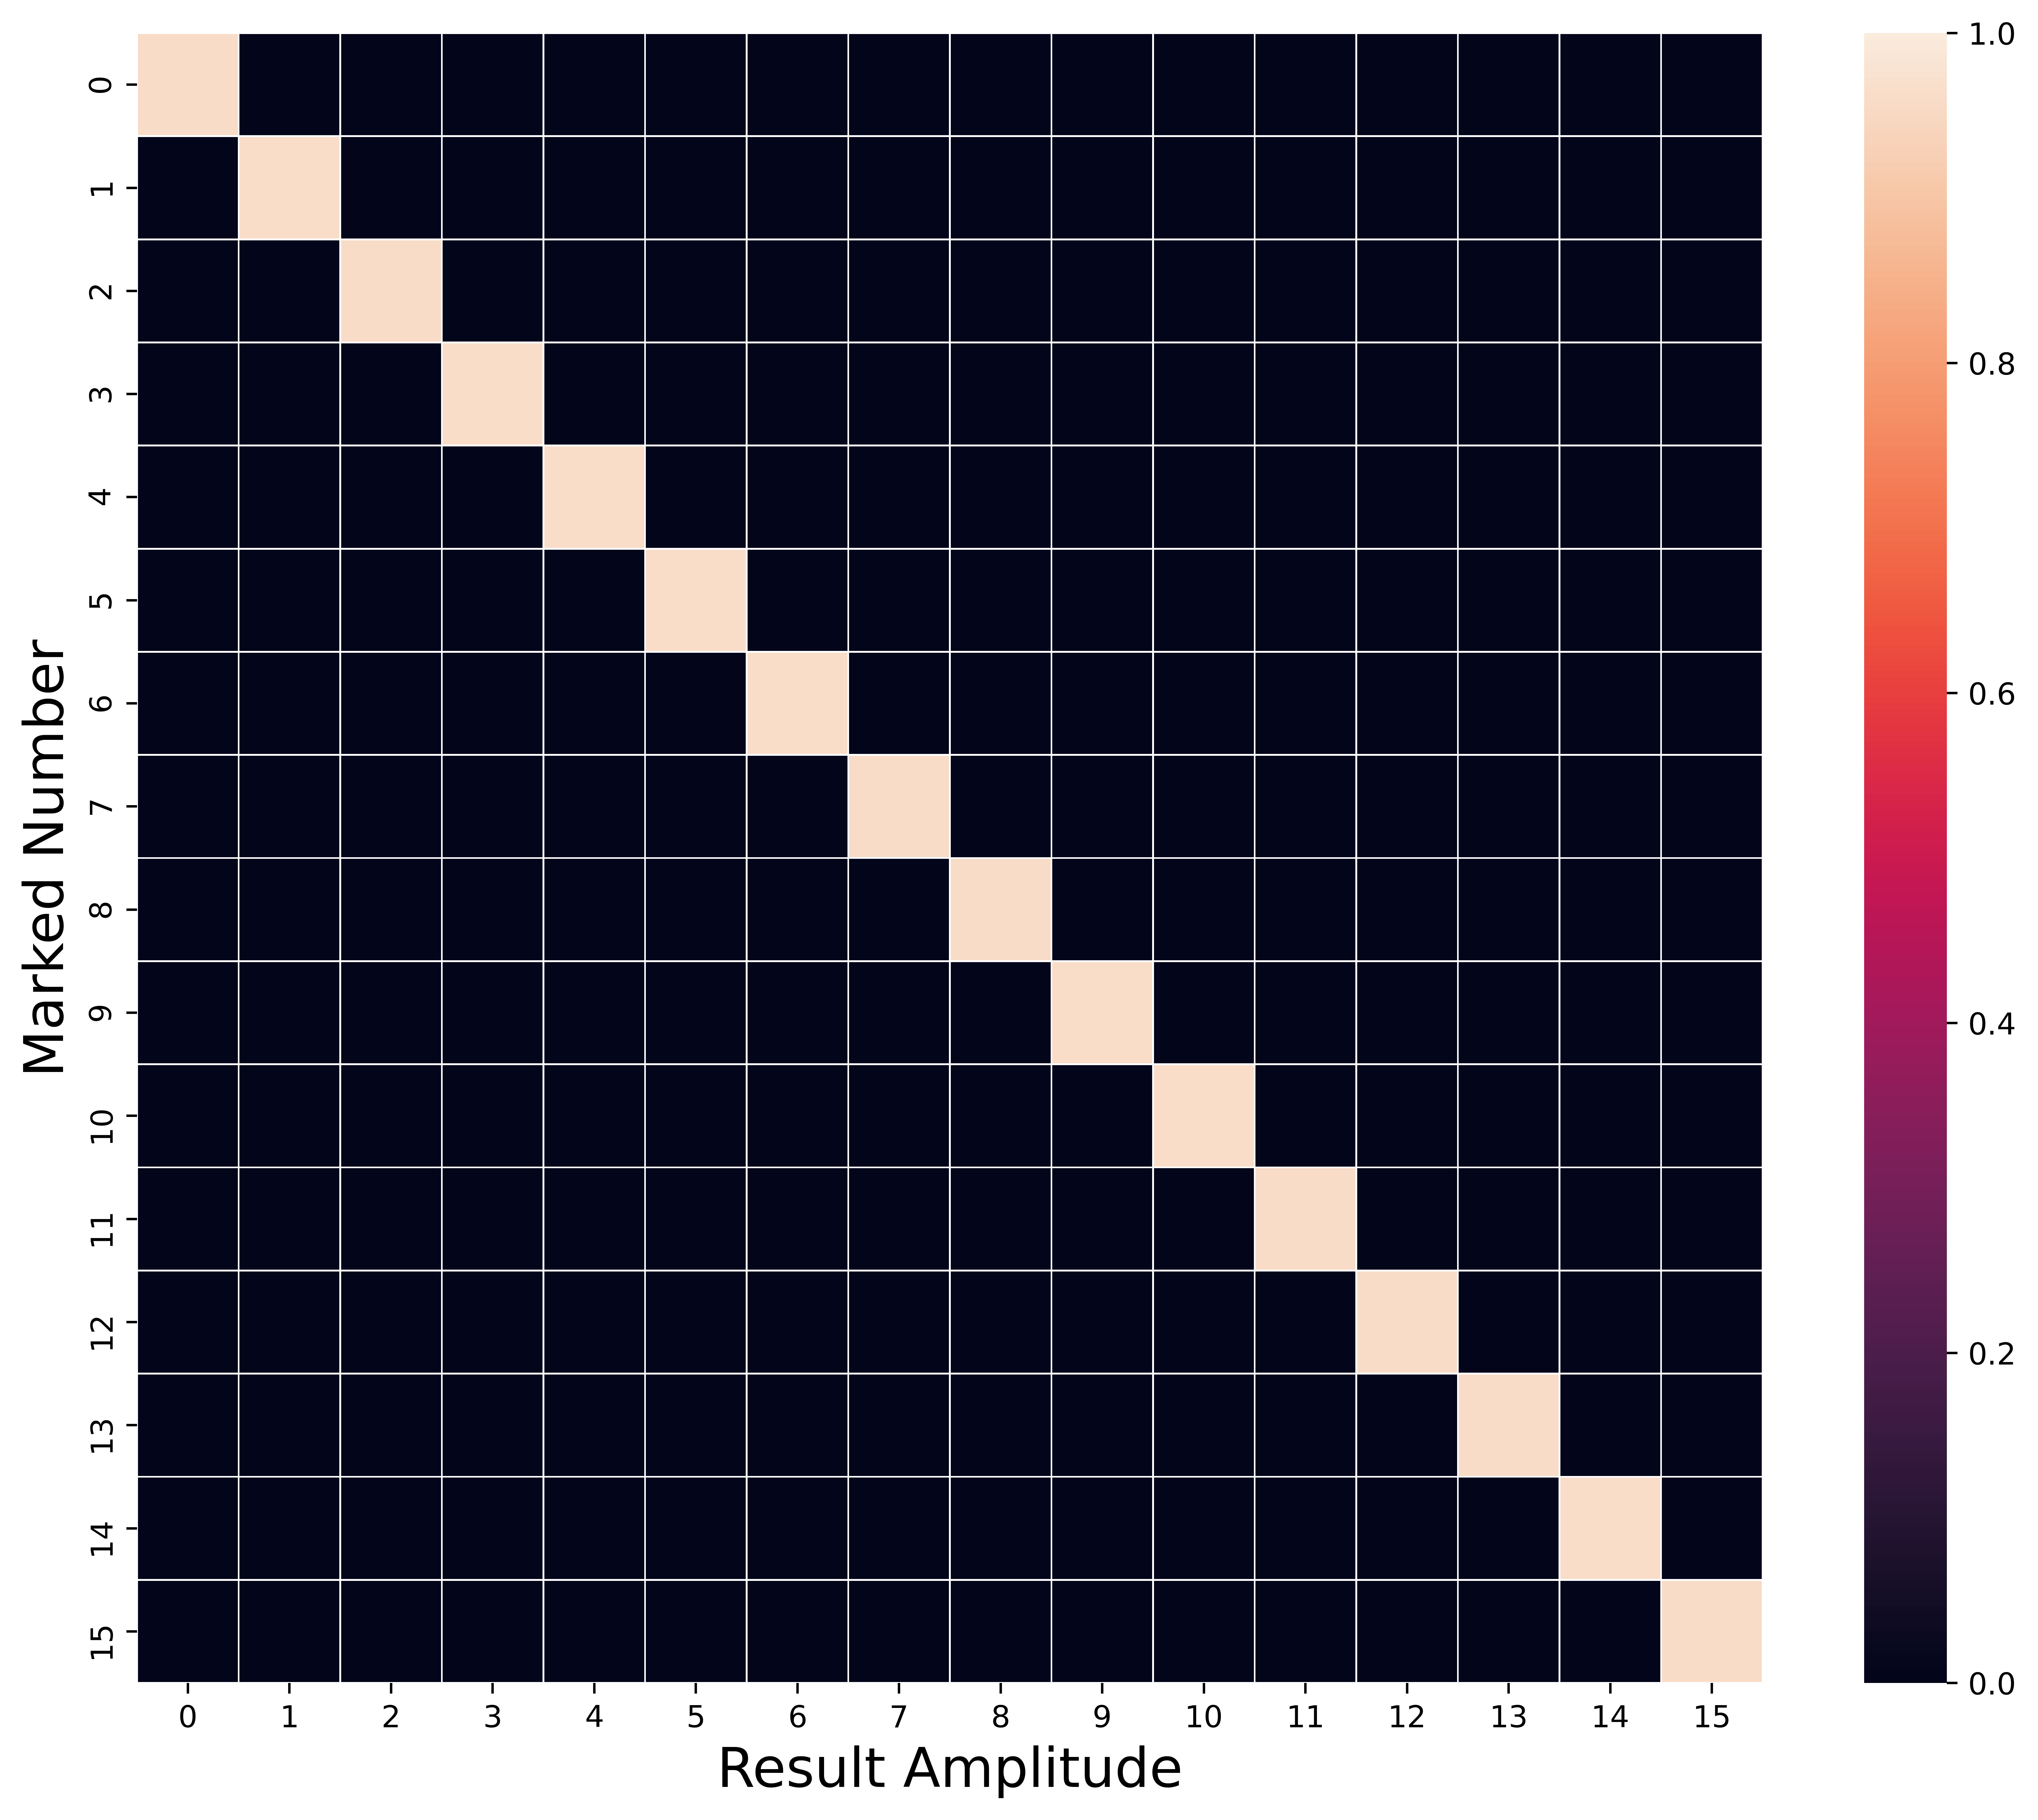

In [149]:
plt.figure(    figsize=(12, 10),    dpi=700)
ax = sns.heatmap(result, linewidth=0.5, vmin = 0, vmax = 1)
plt.ylabel("Marked Number", fontsize=18)
plt.xlabel("Result Amplitude", fontsize=18)
plt.show()

## Real Device <a class="anchor" id="testing_real"></a>

In [152]:
circ_length = 4
t = 3
shots = 40248

result = np.ones((16,16)) * 0.5 #np.zeros((16,16)) 

a = 0
for state in states:
        
    binary_num = ""
    for binary in state:
            
        binary_num += str(binary)
            
    search_pattern = binary_num

    counts = grover_nqubits_device_4qubit(circ_length, search_pattern)
    
    s = 0
    for key in counts:
    
        res = counts[key]
        result[a,s] = res / shots
        s += 1
    a += 1

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [155]:
result

array([[0.00144107, 0.00144107, 0.00163983, 0.00111807, 0.00198768,
        0.00178891, 0.00223614, 0.00176406, 0.00129199, 0.00144107,
        0.00134168, 0.00116776, 0.00176406, 0.00159014, 0.0018386 ,
        0.00159014],
       [0.00139137, 0.00159014, 0.00131684, 0.00114291, 0.00176406,
        0.00149076, 0.00141622, 0.00119261, 0.00231067, 0.00221129,
        0.00159014, 0.00193798, 0.00171437, 0.00154045, 0.00163983,
        0.00119261],
       [0.0015156 , 0.00146591, 0.00136653, 0.00136653, 0.00119261,
        0.00134168, 0.00121745, 0.00134168, 0.00213675, 0.00154045,
        0.00211191, 0.00171437, 0.00196283, 0.00193798, 0.00163983,
        0.00159014],
       [0.00136653, 0.00181375, 0.00173922, 0.00213675, 0.00119261,
        0.00168952, 0.00129199, 0.00171437, 0.00136653, 0.00171437,
        0.00121745, 0.00181375, 0.00141622, 0.00213675, 0.00119261,
        0.00163983],
       [0.00141622, 0.00163983, 0.00134168, 0.0015156 , 0.00114291,
        0.00114291, 0.00096899, 

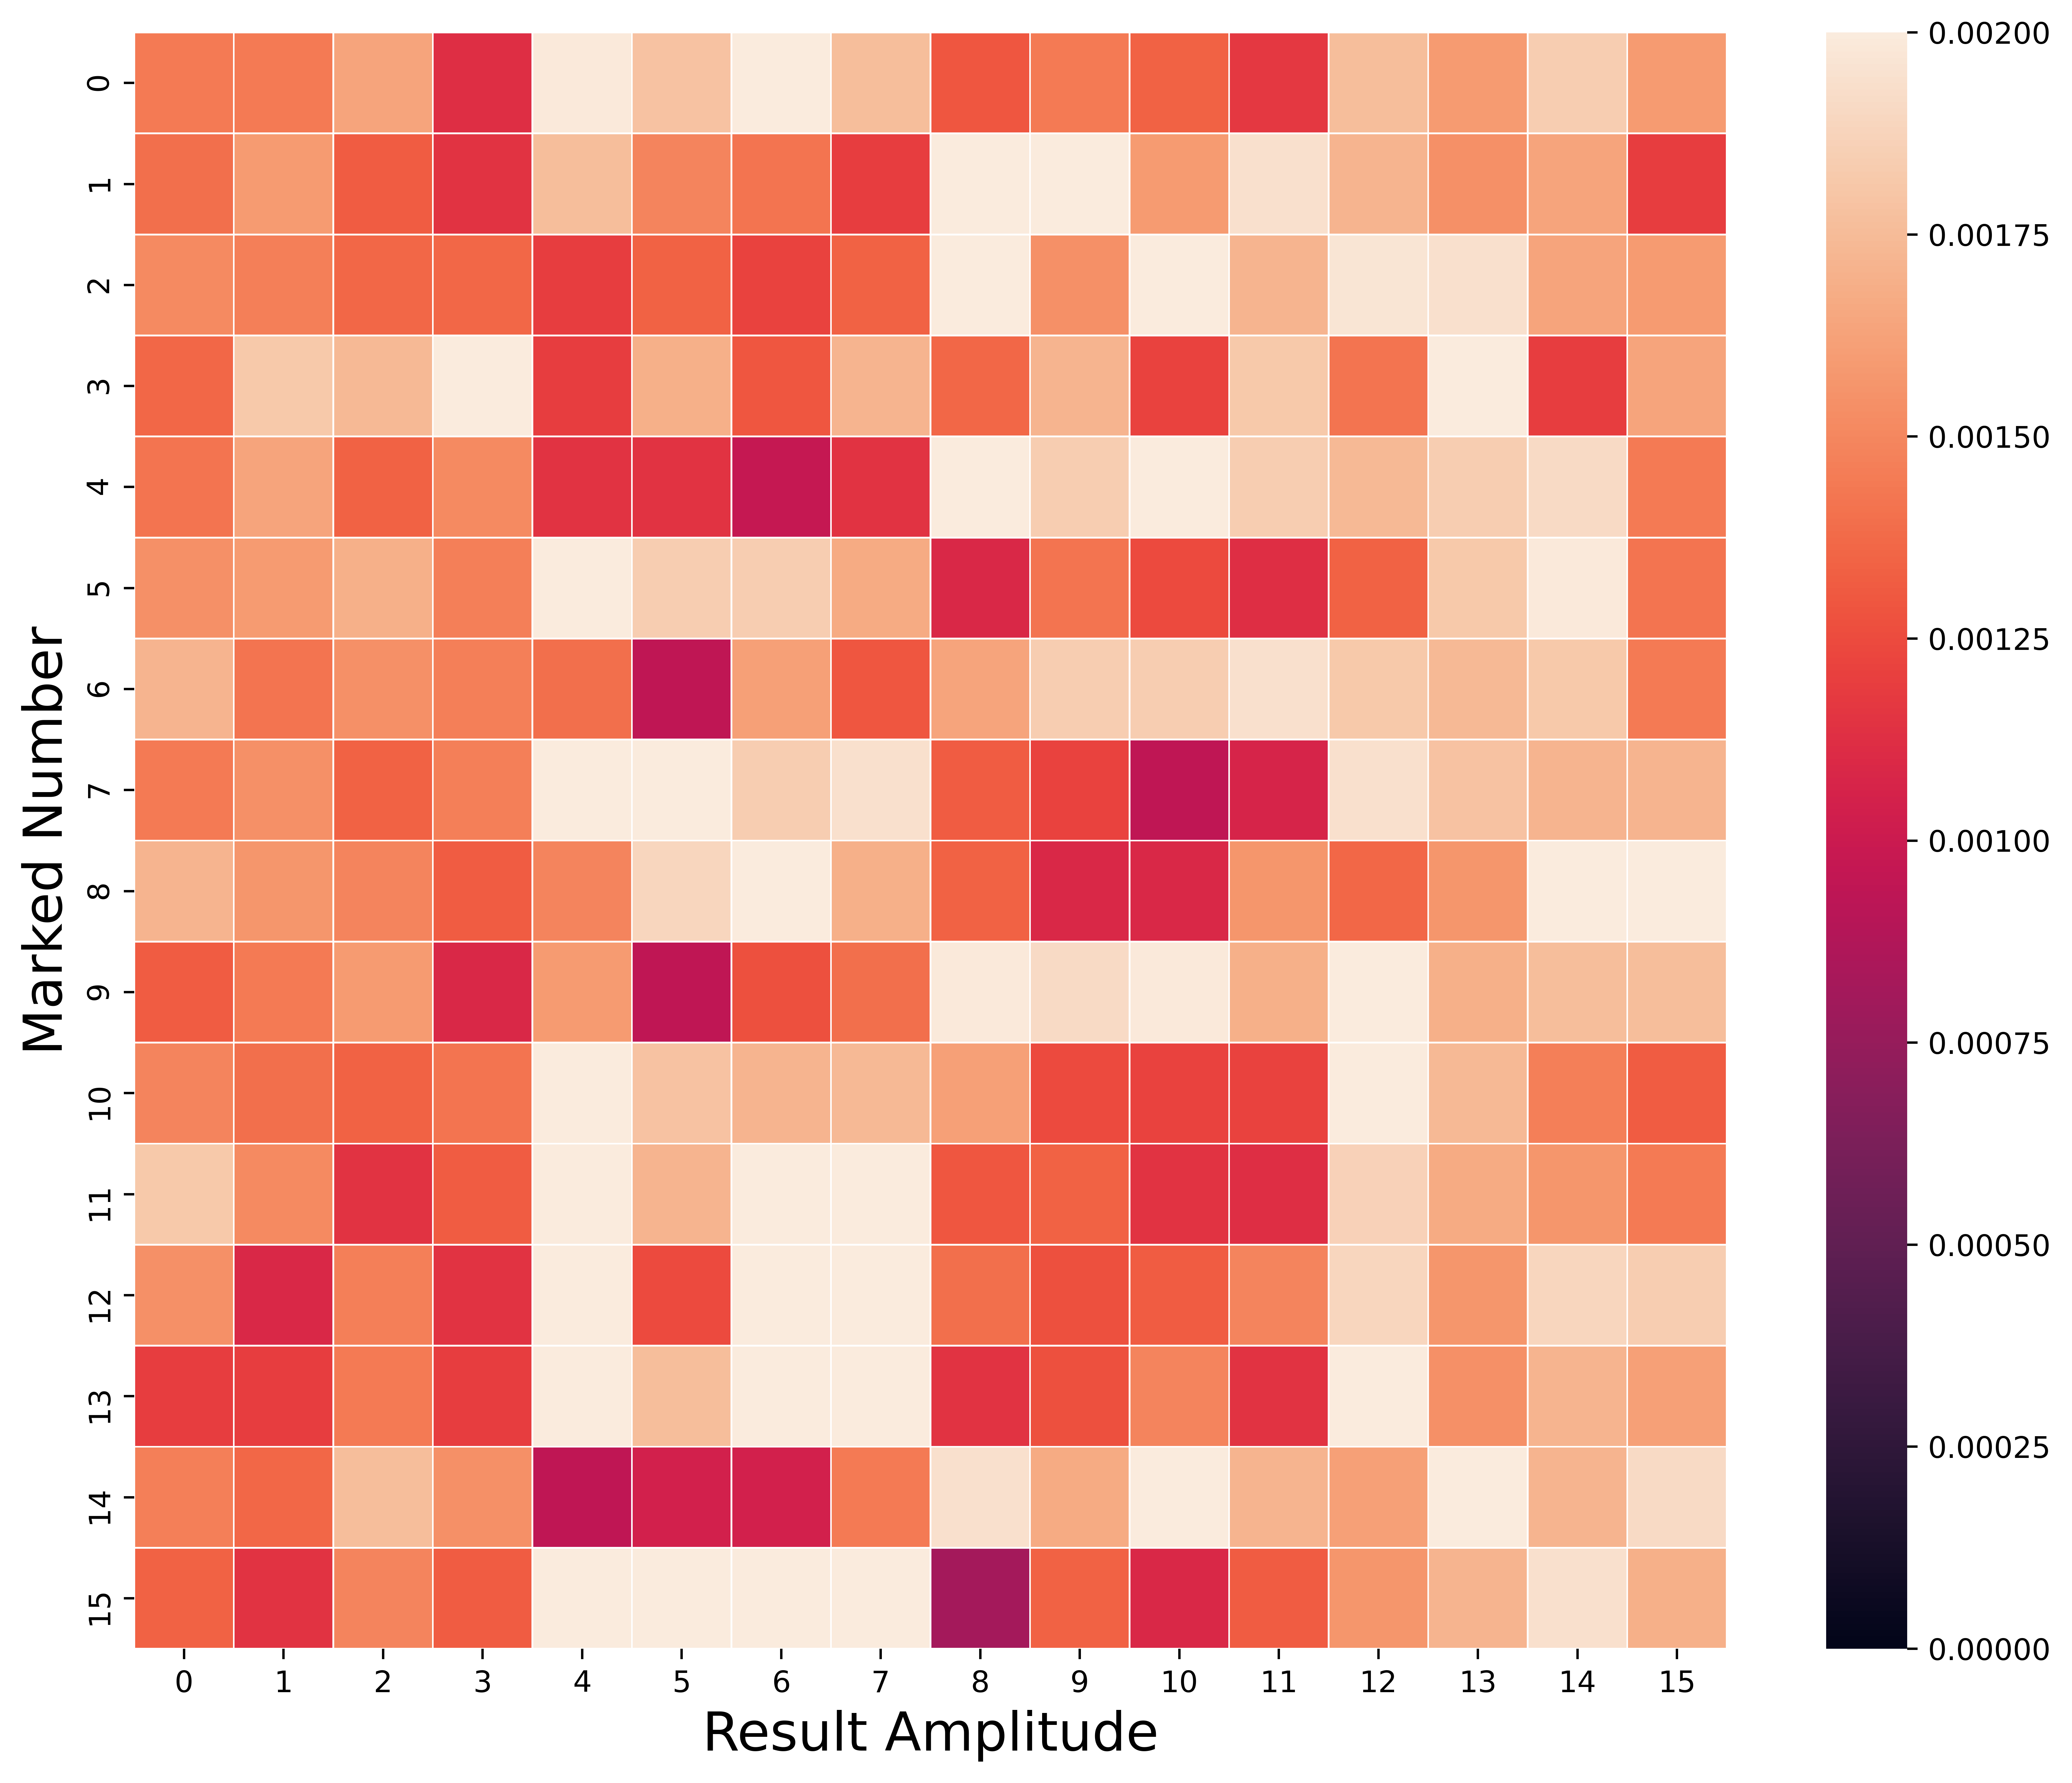

In [158]:
plt.figure(    figsize=(12, 10),    dpi=700)
ax = sns.heatmap(result, linewidth=0.5, vmin = 0, vmax = 0.002)
plt.ylabel("Marked Number", fontsize=18)
plt.xlabel("Result Amplitude", fontsize=18)
plt.show()

In [162]:
def grover_nqubits_device_4qubit_backend(circ_length, search_pattern,backend):
    
    search_pattern = str(search_pattern)
    
    ##################################
    
    init = QuantumCircuit(circ_length)

    for i in range(circ_length):
        init.h(i)
    init.barrier()
    
    ####################################
    
    oracle = QuantumCircuit(circ_length)

    oracle.barrier()
    x_s = -1
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle.x(x_s)

    cnz = controlled_nz(circ_length)
    oracle_flipped = oracle + cnz

    x_s = -1
    for i in search_pattern:
        x_s += 1
        x = int(i)
        if x == 0:
            oracle_flipped.x(x_s) 
    oracle_flipped.barrier()
    
    ####################################
    
    amp = QuantumCircuit(circ_length)

    amp.barrier()
    for q in range(circ_length):
        amp.h(q)
        amp.x(q)

    amp.barrier()
    amp_flipped = amp + cnz
    amp_flipped.barrier()
    for q in range(circ_length):
        amp_flipped.x(q)
        amp_flipped.h(q)
        
    amp_flipped.barrier()
    
    ####################################
    
    meas = QuantumCircuit(circ_length,circ_length)

    meas.measure(range(circ_length),range(circ_length))
    
    ####################################
    
    circuit = init + ( oracle_flipped + amp_flipped ) + ( oracle_flipped + amp_flipped ) + meas
    
    from qiskit.visualization import plot_histogram
    from qiskit.tools.monitor import job_monitor

    # set the right provider and backend
    provider=IBMQ.get_provider(hub='ibm-q-education', group='tum-filipp-su20', project='ph2299')

    backend=provider.get_backend('ibmq_16_melbourne')

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job = execute(circuit, backend, shots=4048)
    job_monitor(job)

    # Grab the results from the job.
    result = job.result()
    counts = result.get_counts(circuit)

    
    return counts

In [163]:
circ_length = 4
t = 3
shots = 40248

result = np.ones((16,16)) * 0.5 #np.zeros((16,16)) 

a = 0
for state in states:
        
    binary_num = ""
    for binary in state:
            
        binary_num += str(binary)
            
    search_pattern = binary_num

    counts = grover_nqubits_device_4qubit_backend(circ_length, search_pattern, 'ibmq_16_melbourne')
    
    s = 0
    for key in counts:
    
        res = counts[key]
        result[a,s] = res / shots
        s += 1
    a += 1

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job is queued (1)     

KeyboardInterrupt: 

In [164]:
result

array([[0.0076774 , 0.00693202, 0.00678295, 0.00663387, 0.00747863,
        0.00715564, 0.00581395, 0.00536673, 0.00623633, 0.00586365,
        0.00603757, 0.00506857, 0.00710594, 0.0055158 , 0.00566488,
        0.0052425 ],
       [0.00650964, 0.00655933, 0.00660902, 0.0061618 , 0.00593818,
        0.0052425 , 0.00593818, 0.00571457, 0.00648479, 0.00598788,
        0.00842278, 0.00742894, 0.00603757, 0.00576426, 0.0064351 ,
        0.00534188],
       [0.00688233, 0.00631087, 0.00613695, 0.00588849, 0.00603757,
        0.00571457, 0.00544126, 0.00559034, 0.00695687, 0.00653449,
        0.00683264, 0.00621149, 0.00750348, 0.0064351 , 0.00670841,
        0.00539157],
       [0.00660902, 0.00718048, 0.00641026, 0.00581395, 0.00650964,
        0.00596303, 0.00511827, 0.00531703, 0.00673325, 0.00628603,
        0.00685748, 0.00683264, 0.00685748, 0.00576426, 0.00596303,
        0.00636056],
       [0.00807494, 0.00723017, 0.0064351 , 0.00603757, 0.0064351 ,
        0.00593818, 0.00621149, 

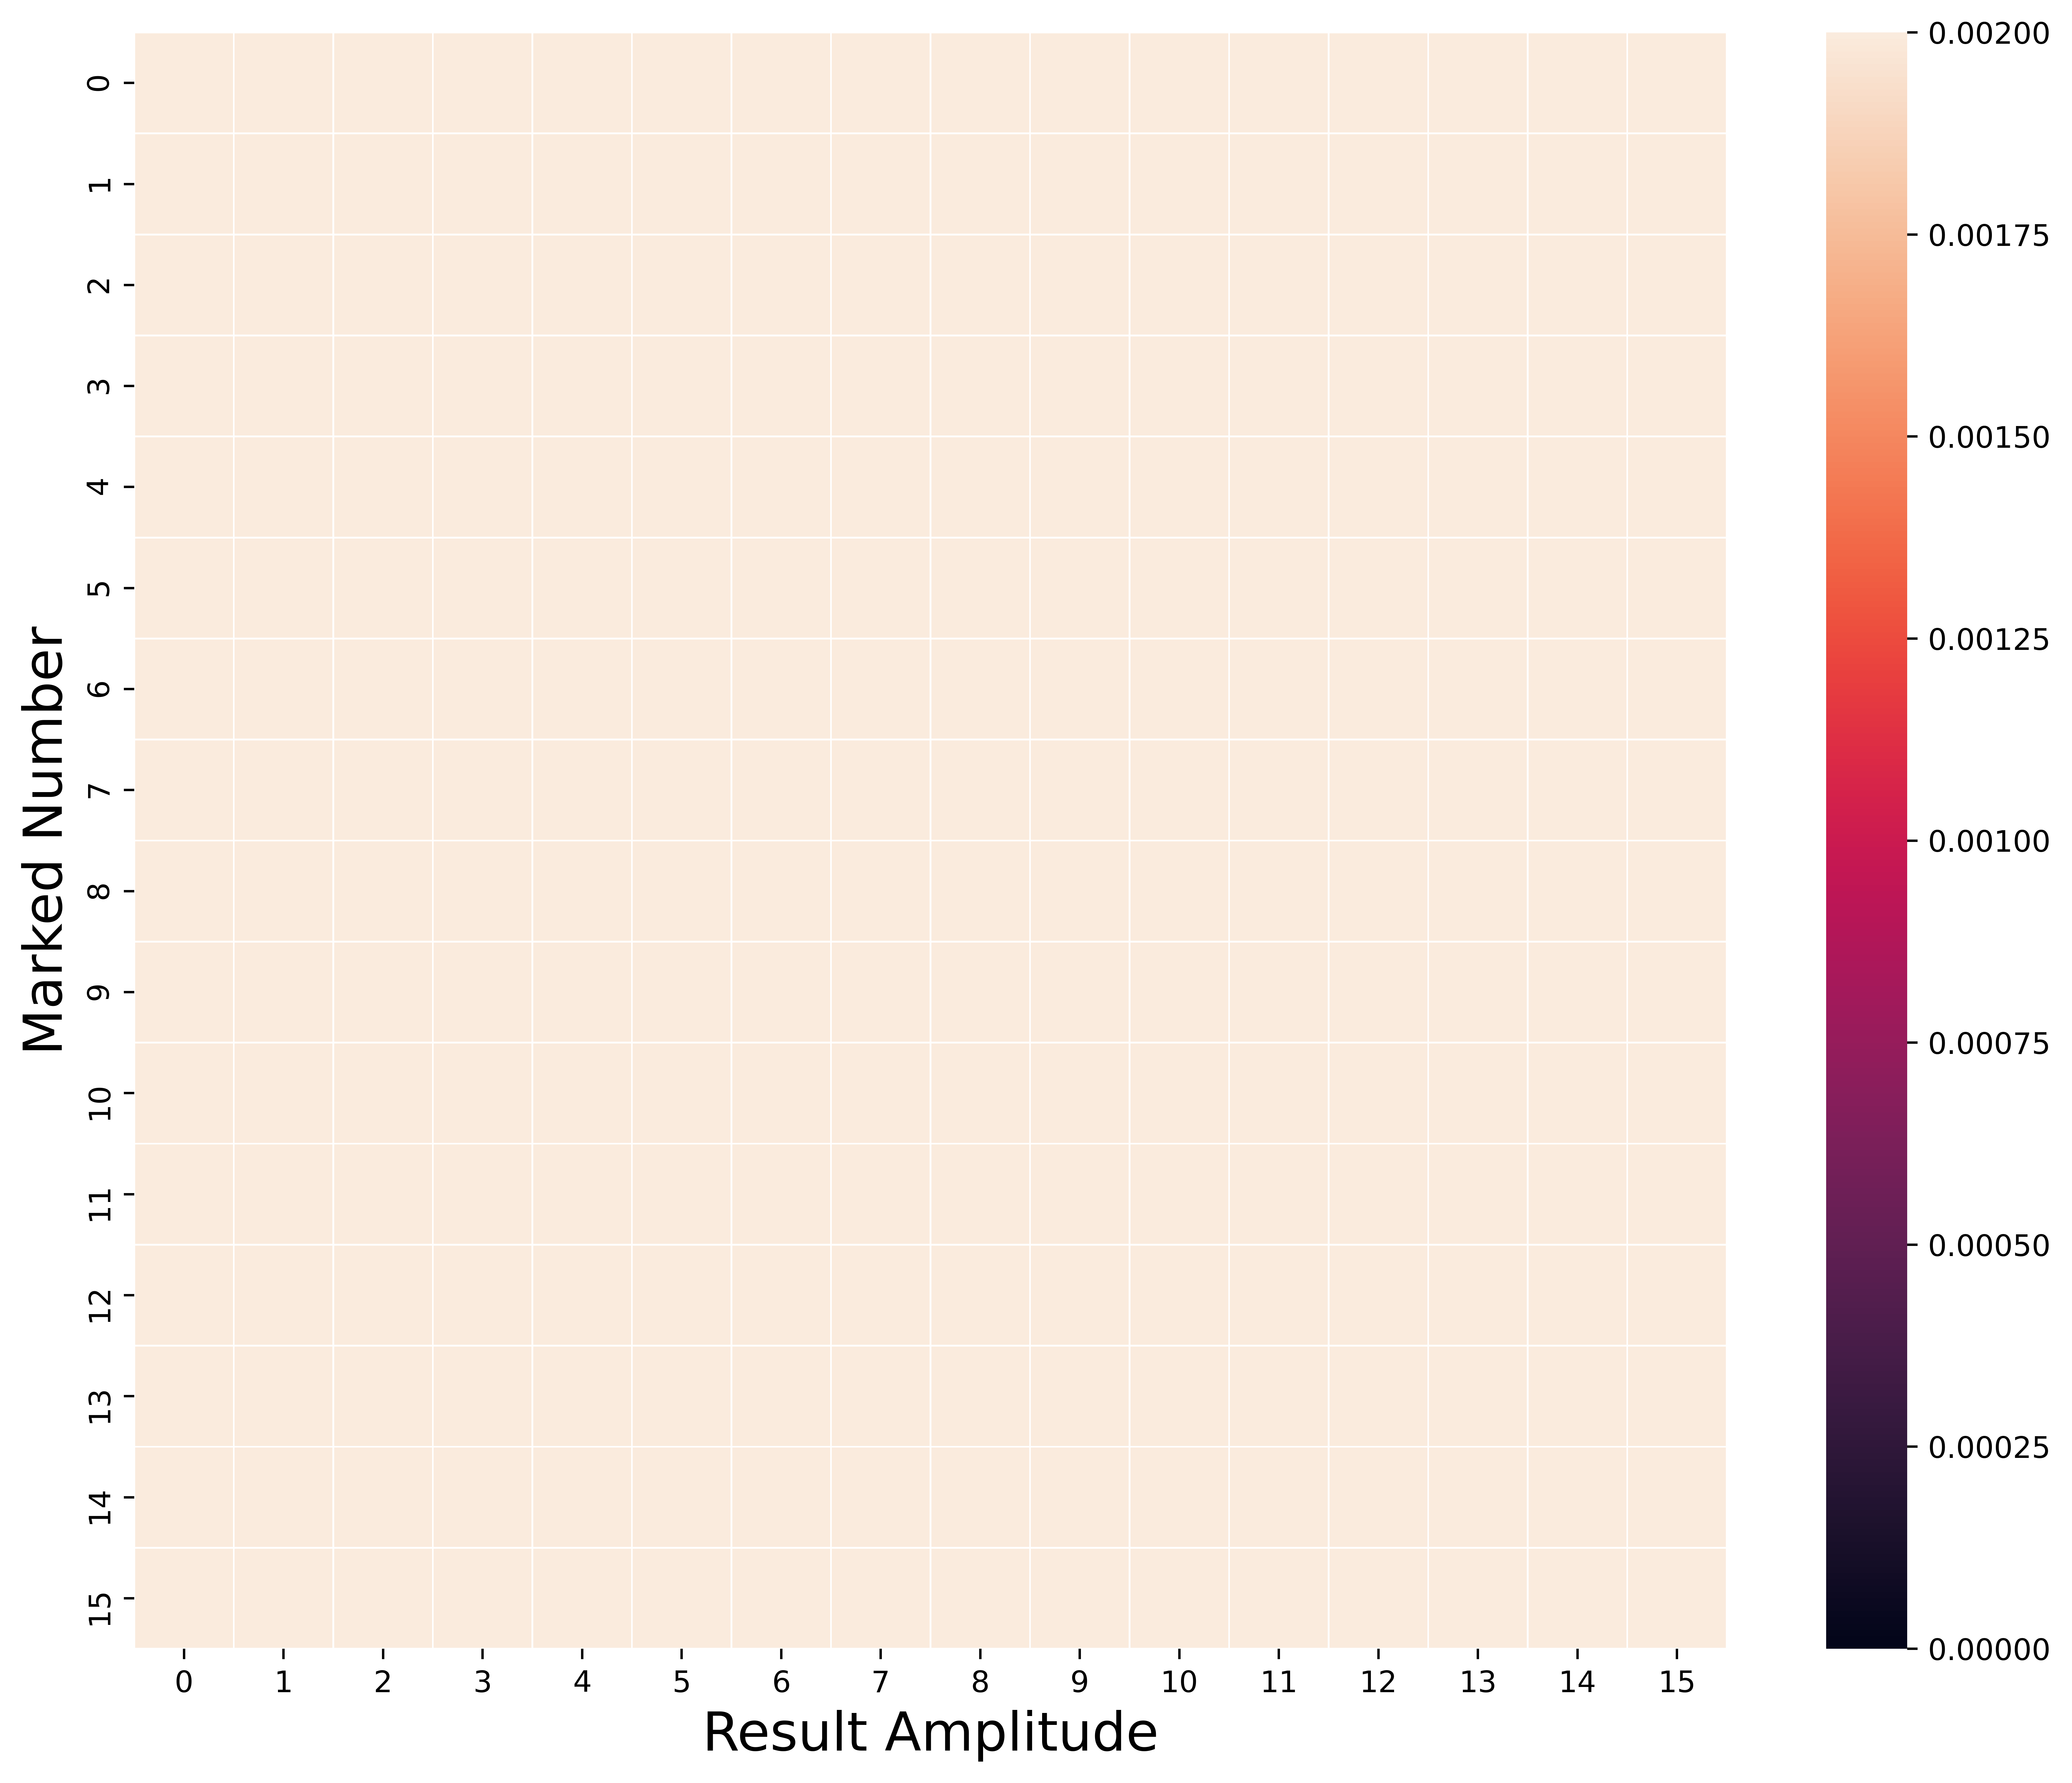

In [165]:
plt.figure(    figsize=(12, 10),    dpi=700)
ax = sns.heatmap(result, linewidth=0.5, vmin = 0, vmax = 0.002)
plt.ylabel("Marked Number", fontsize=18)
plt.xlabel("Result Amplitude", fontsize=18)
plt.show()